In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import os

TREBL_ROOT = os.path.abspath("../../../TREBL")  # adjust if needed
if TREBL_ROOT not in sys.path:
    sys.path.insert(0, TREBL_ROOT)

from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct

import glob
from tqdm import tqdm  # progress bar

In [3]:
step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "CTCGAGATAACTTCGTATAATGTATGCTAT",
                       post = "GGCCGGCCATAGGGCCCC",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "GAGCTCGCTAGC",
                       post = "CTCGAGATAA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GGCCGGCCATAGGGCCCC",
                       post = "GCGGTCCA",
                       length = 16)

step1_AD = finder.Barcode(name = "AD",
                       preceder = "CACCATG",
                       post = "GGATCCG",
                       length = 162)

In [4]:
mapper = initial_map.InitialMapper(db_path = "../../duckdb/NKX2-2-full.db",
                       seq_file = ['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq'],
                        bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                      reverse_complement=False,
                        step_name = "step1")
#mapper.create_map()

In [5]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 15252011


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  CAAGAC        True  ATCGCCTTC          True  TACAGGTTATCGTCAA       True   
1  GTTAAA        True  ATAAGCGCC          True  CCAGATGCAATAGTTT       True   
2  ATTTTG        True                    False  ACGTCAACAAGTACAA       True   
3  ATAACA        True  ACGCCTGAA          True  AATATTTATCACTATT       True   
4  GCGTGT        True  CCGAATTGA          True  AATTACATAATACACG       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     True         1  
1  GCTCCCGACCTGGCCGCCGCCACCTTTCCCGCCGGCATTCCCTTCA...     True         1  
2  GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
4  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...     True         1

In [6]:
# mapper.generate_fastq_for_whitelist("../../data/NKX2-2_whitelist_test_function/")

In [6]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2-full.db",
                                    bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                    column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                                    design_check = True, 
                                    reads_threshold = 5,
                                    map_order = [
                                        "barcode_exists",
                                        "quality",
                                        "error_corrected",
                                        "grouped",
                                        "thresholded",
                                        "unique_target",
                                        "designed"
                                    ],
                                    step_name = "step1",
                                    design_file = "../../data/DNA_Tiles_nkx2_2.txt",
                                        should_check_exists = False, 
                                         plot_histograms = True,
                                        min_fraction = 0.9,
                                        descriptor = "overlap_prop",
                                    output_figures_path = "../../output/NKX2-2_step1_figs")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. unique_target
8. designed



Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.53 seconds.


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_quality — filtered for TRUE in all *_qual columns.
Done in 3.16 seconds.


=== Running error correction step on step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_quality ===

=== Applying whitelist for step1 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq
Wrote 2915005 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq
Done in 3.11 seconds.

Running umi_tools whitelist...
Running umi_tools whitelist on step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq ...


/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_plots_*.png
Unique canonical barcodes: 1757


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 4.18 seconds.

Whitelist application complete for step1 at step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_error_corrected
Done in 2.96 minutes.

Grouping step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_error_corrected...


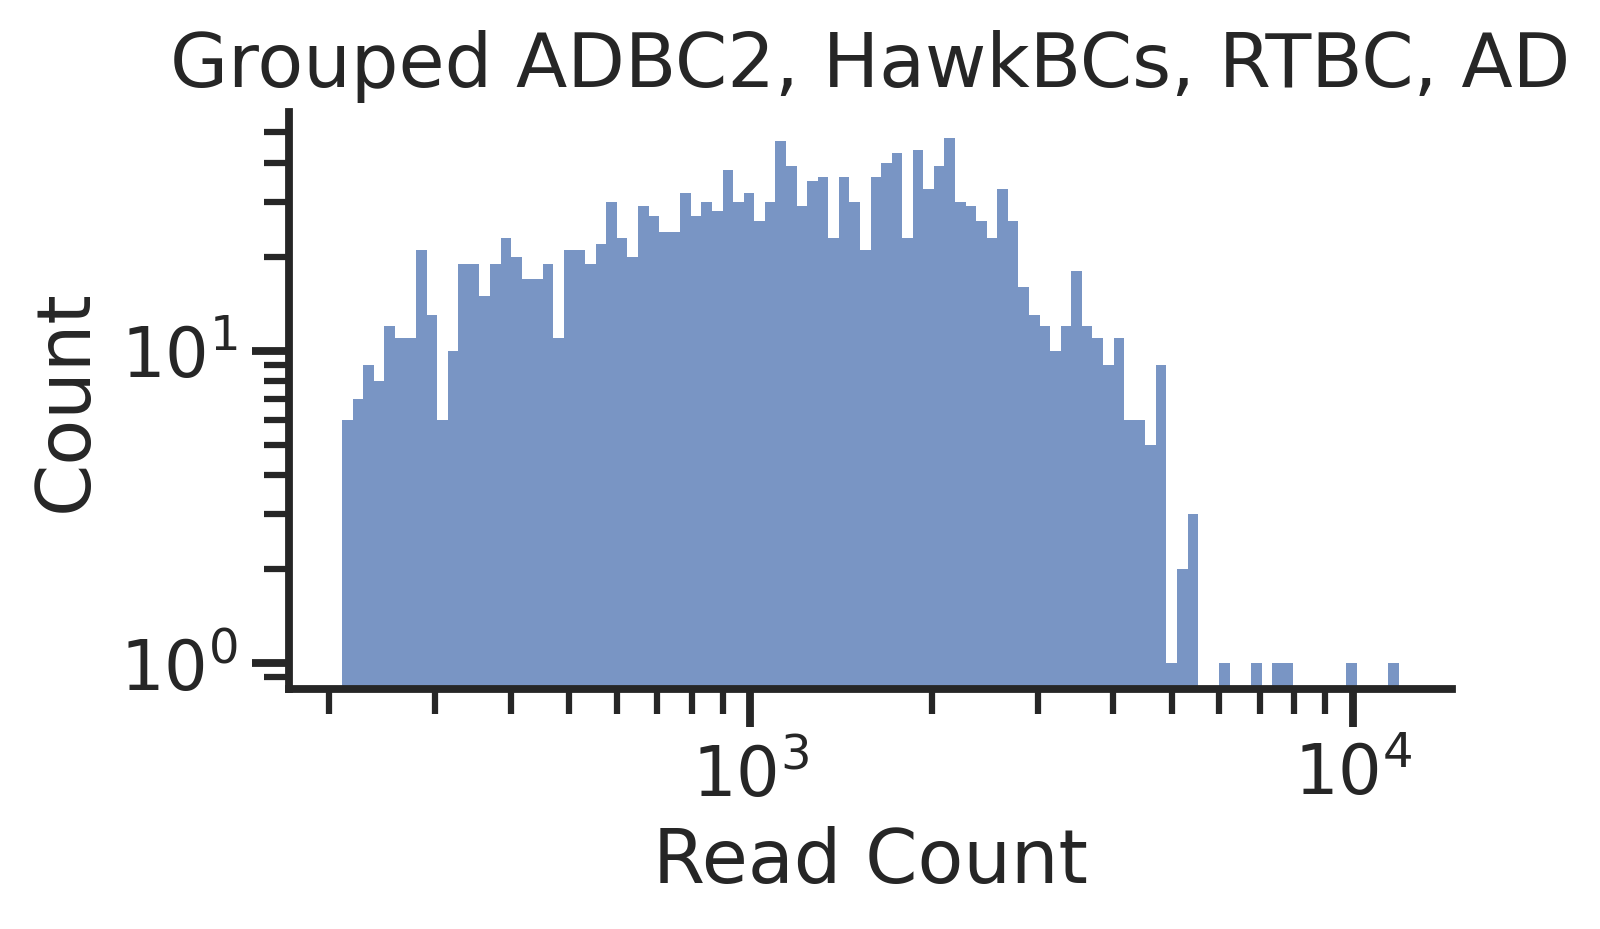

Done in 0.92 seconds.

Thresholding...
Using reads threshold of 5.


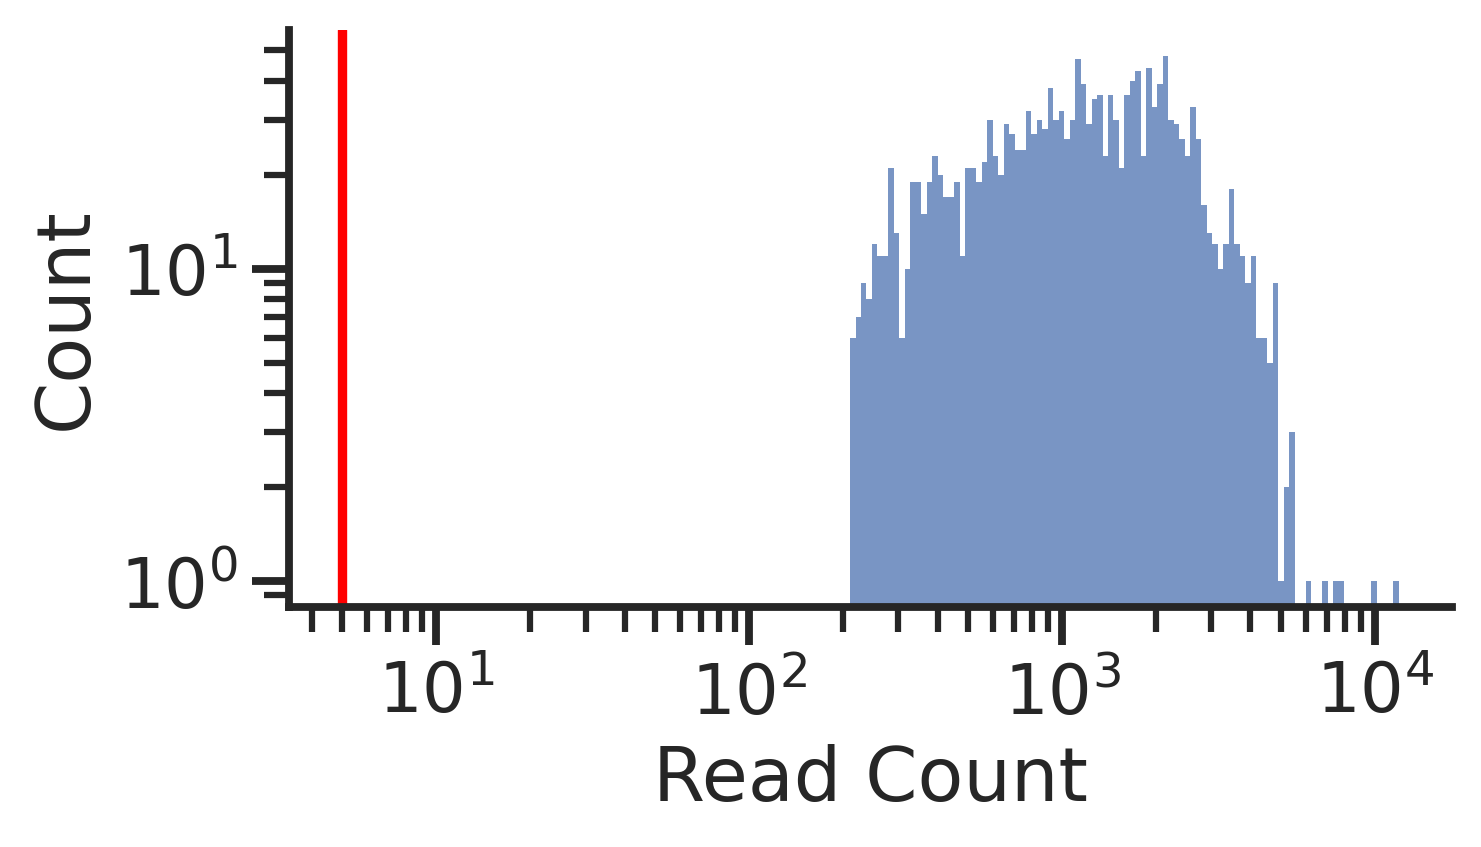

Done in 0.61 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_unique_target
Done in 0.05 seconds.


Filtering to designed sequences...
Created table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.


In [8]:
refiner.refine_map_from_db()

In [17]:
error_corrected = refiner.get_map_df('error_corrected')
error_corrected

ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  \
0        GAACTA        True  AGTGTAACC          True  TAGGTCTTCTGTTTAC   
1        ACTAGA        True  CAGACAGCA          True  TGCGGGCGAGATTTTG   
2        AACTAG        True  ACACTAACC          True  GGAATCGGTAGAAGAT   
3        CAAAAT        True  ACCTCGATT          True  GTAGACTCGGGGGGGC   
4        TATCAA        True  AACAGAGTC          True  AATTATTTCCTACATT   
...         ...         ...        ...           ...               ...   
2509543  TGAGTT        True  AACGAATGC          True  AAGACATACGAGCTAT   
2509544  CCTAGC        True  CCAAGGTGT          True  GTCGGATATTCATCCA   
2509545  TCATAT        True  CAATCTCTC          True  AACAGGAAACATGAAT   
2509546  ATTGAC        True  ATACCGTCG          True  AATTCGATTTTTTGAC   
2509547  ATCTGA        True  CCGCAGTTA          True  AGAAAACACATATTCT   

         RTBC_qual                                                 AD  \
0             True  GCCCAGGACTTCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
1             True  GCCACCGACCTGGCCGCCGCCACCTTCACCGCCGGCATTCCCTTCA...   
2             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
3             True  GCCCAGGACCTGGCCGCCGCCACCTTCAGCGCCGGCATTCCCTTCA...   
4             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
...            ...                                                ...   
2509543       True  GCCGAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2509544       True  AGACTGCTGGGCCAGAGCATGGACGAGAGCGGCCTGCCTCAGCTGA...   
2509545       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...   
2509546       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCGCCA...   
2509547       True  ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...   

         AD_qual  Designed  
0           True         1  
1           True         1  
2           True         1  
3           True         1  
4           True         1  
...          ...       ...  
2509543     True         0  
2509544     True         0  
2509545     True         0  
2509546     True         0  
2509547     True         0  

[2509548 rows x 9 columns]

In [18]:
# error_corrected[["ADBC2", "HawkBCs", "RTBC", "AD"]].drop_duplicates()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.10 seconds.



Text(0.5, 1.0, 'CC NKX2-2 Step 1:\nDensity Knee Whitelist')

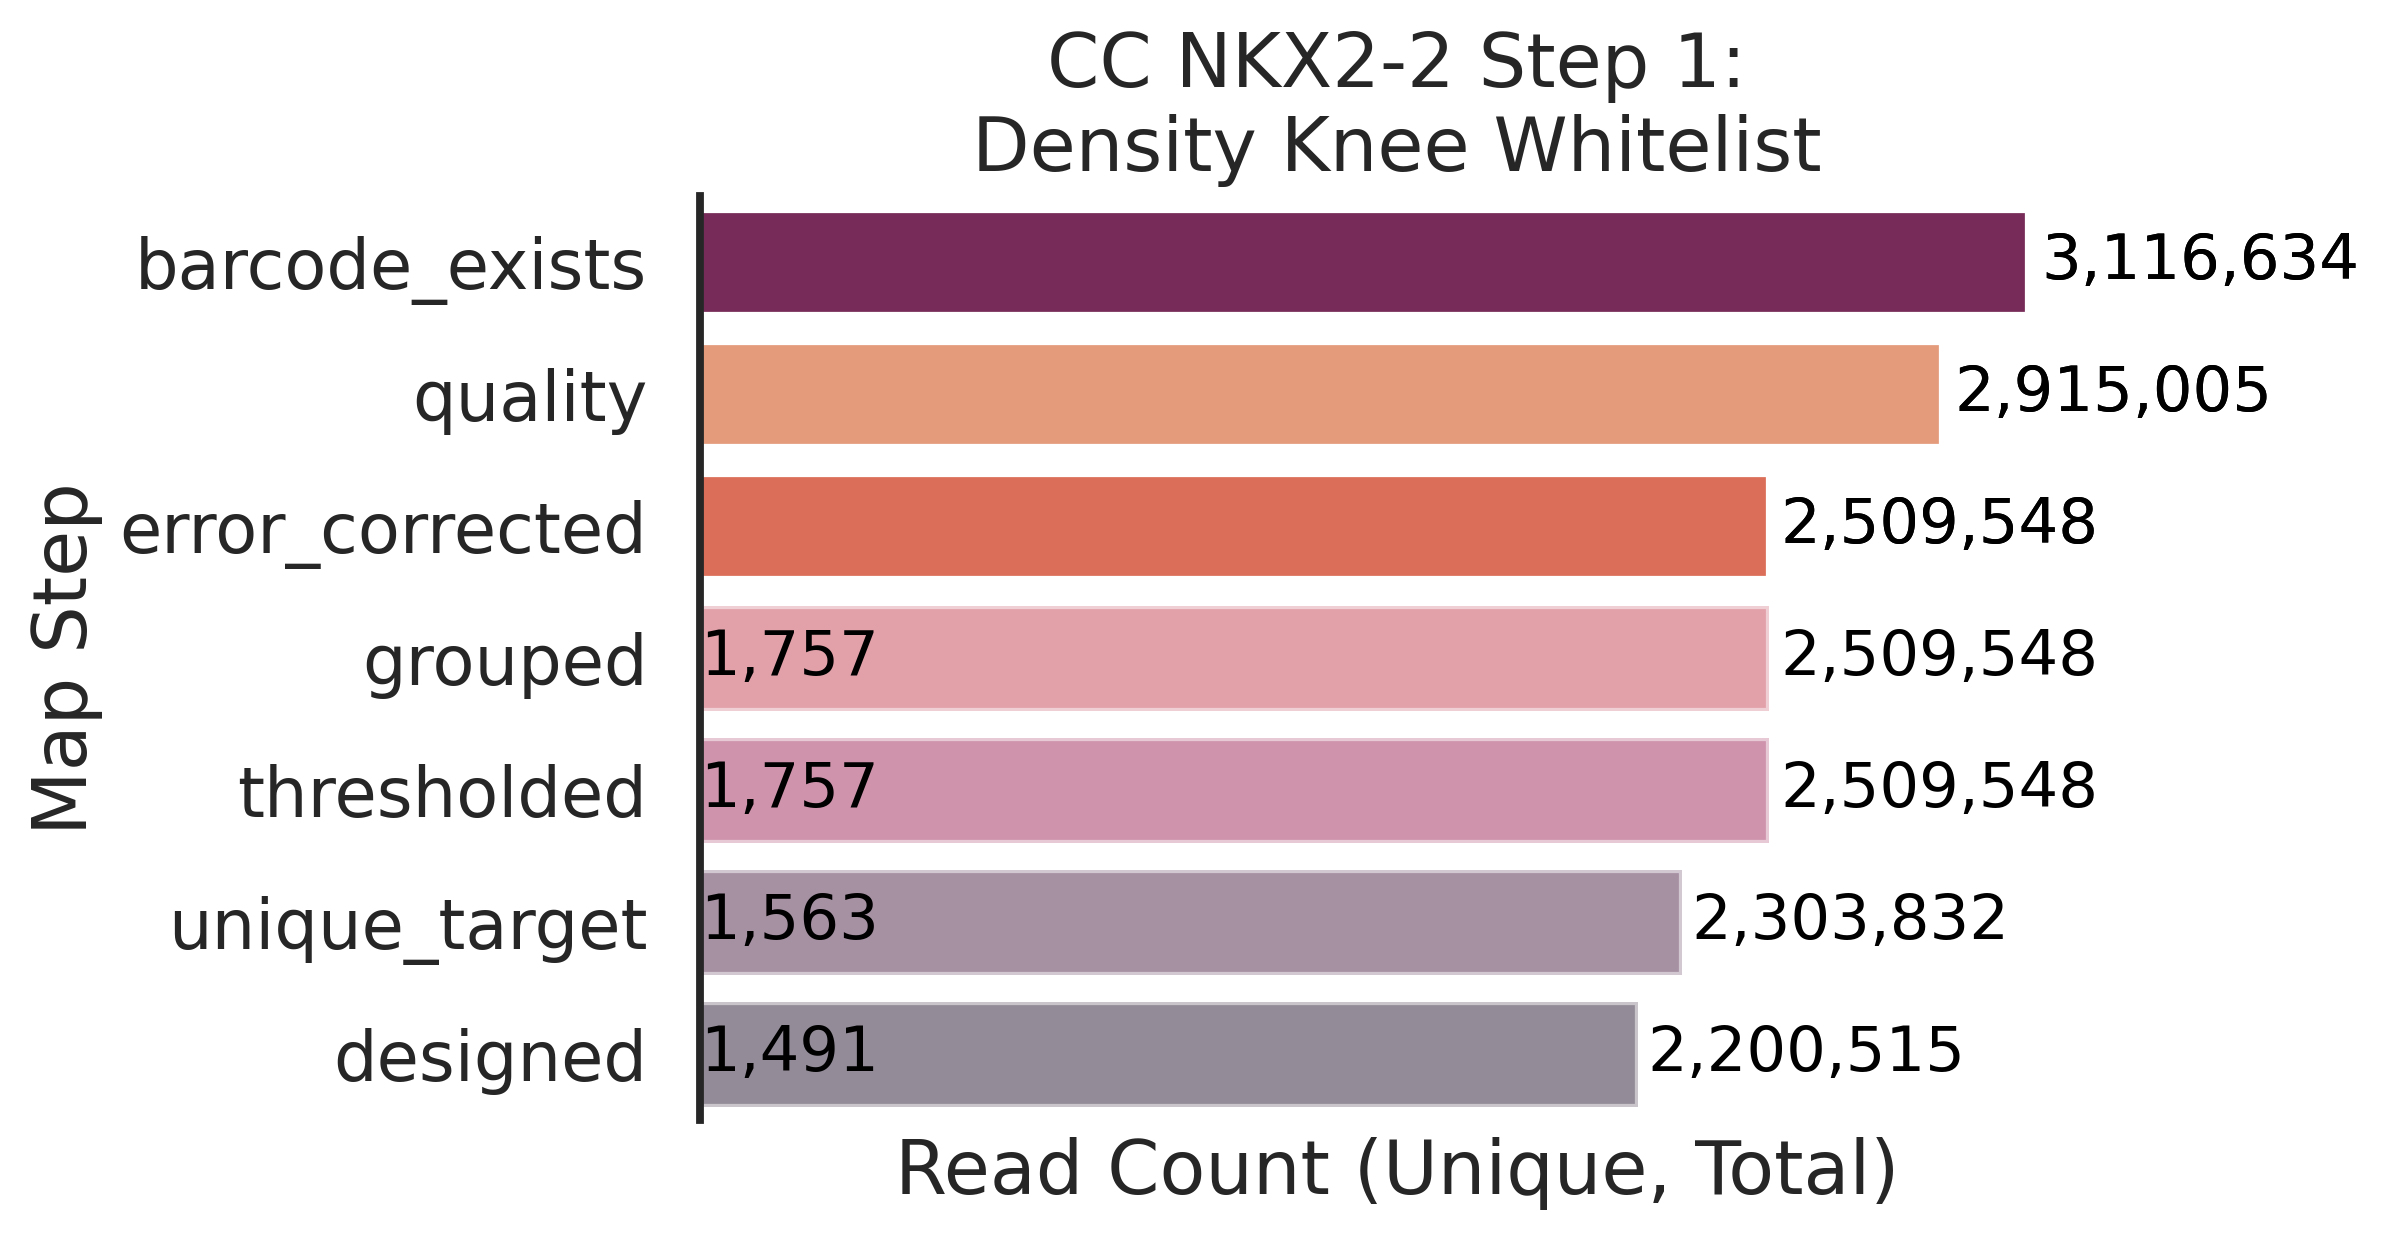

In [19]:
ax = refiner.plot_loss()
ax.set_title("CC NKX2-2 Step 1:\nDensity 
#ax.set_xscale('log')

['error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt']


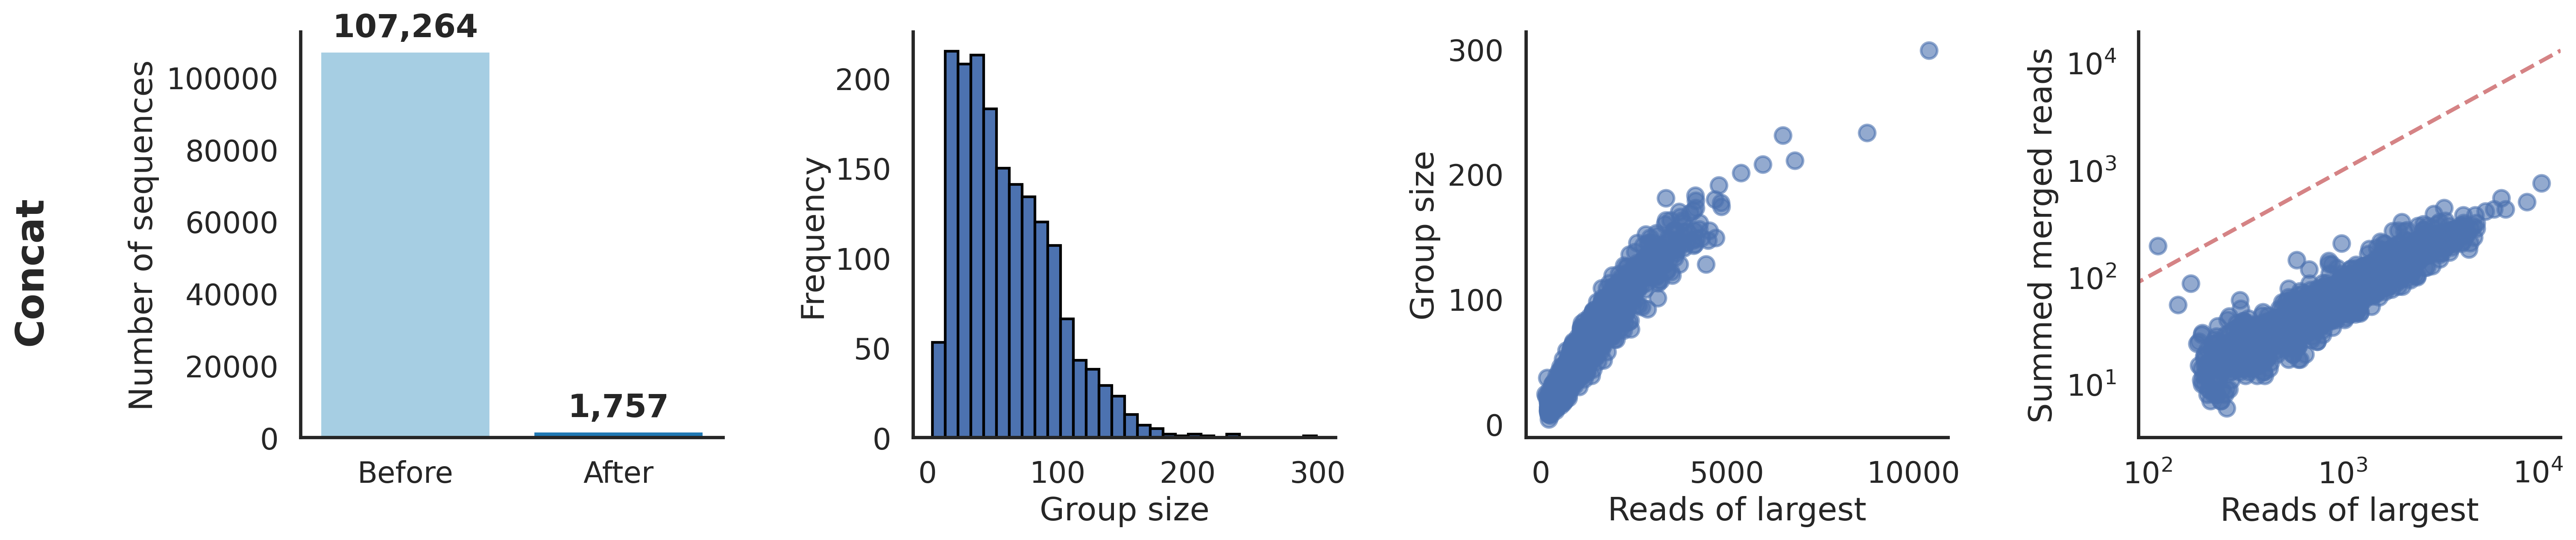

Done in 2.08 seconds.



In [8]:
refiner.plot_error_correction()

In [9]:
refiner.get_map_df('designed').to_csv("../../output/NKX2-2_whitelist_concat_density_step1_map.csv")

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. grouped
5. thresholded
6. unique_target
7. designed

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.55 seconds.


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: step1_ADBC2_HawkBCs_RTBC_AD_quality — filtered for TRUE in all *_qual columns.
Done in 3.08 seconds.

Grouping step1_ADBC2_HawkBCs_RTBC_AD_quality...


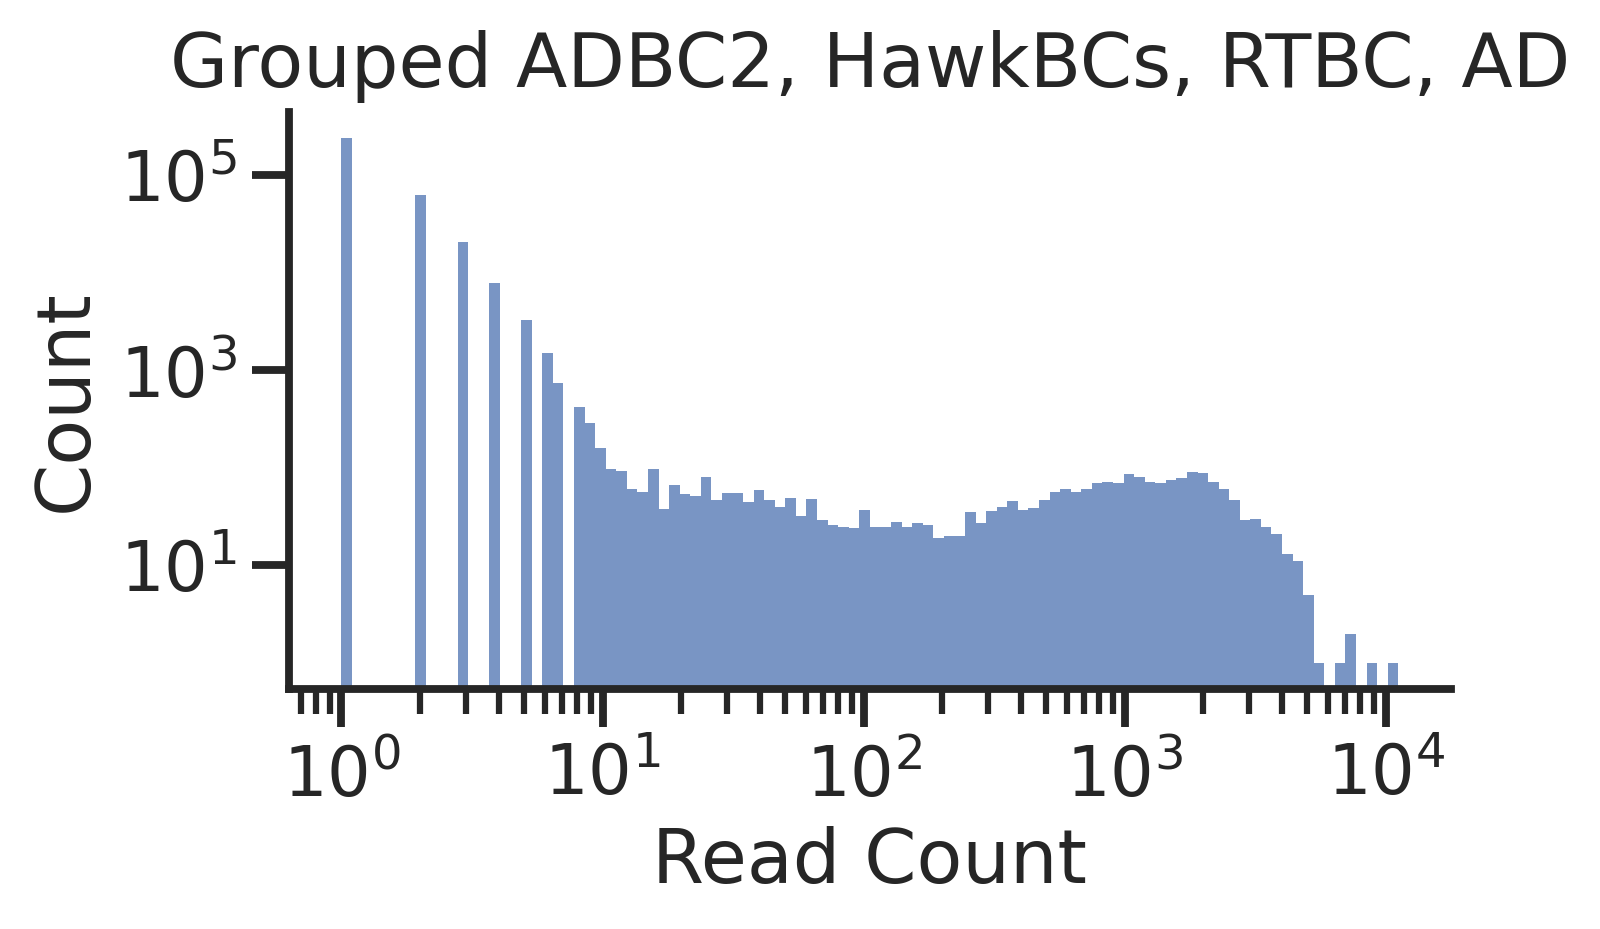

Done in 1.36 seconds.

Thresholding...
Using reads threshold of 5.


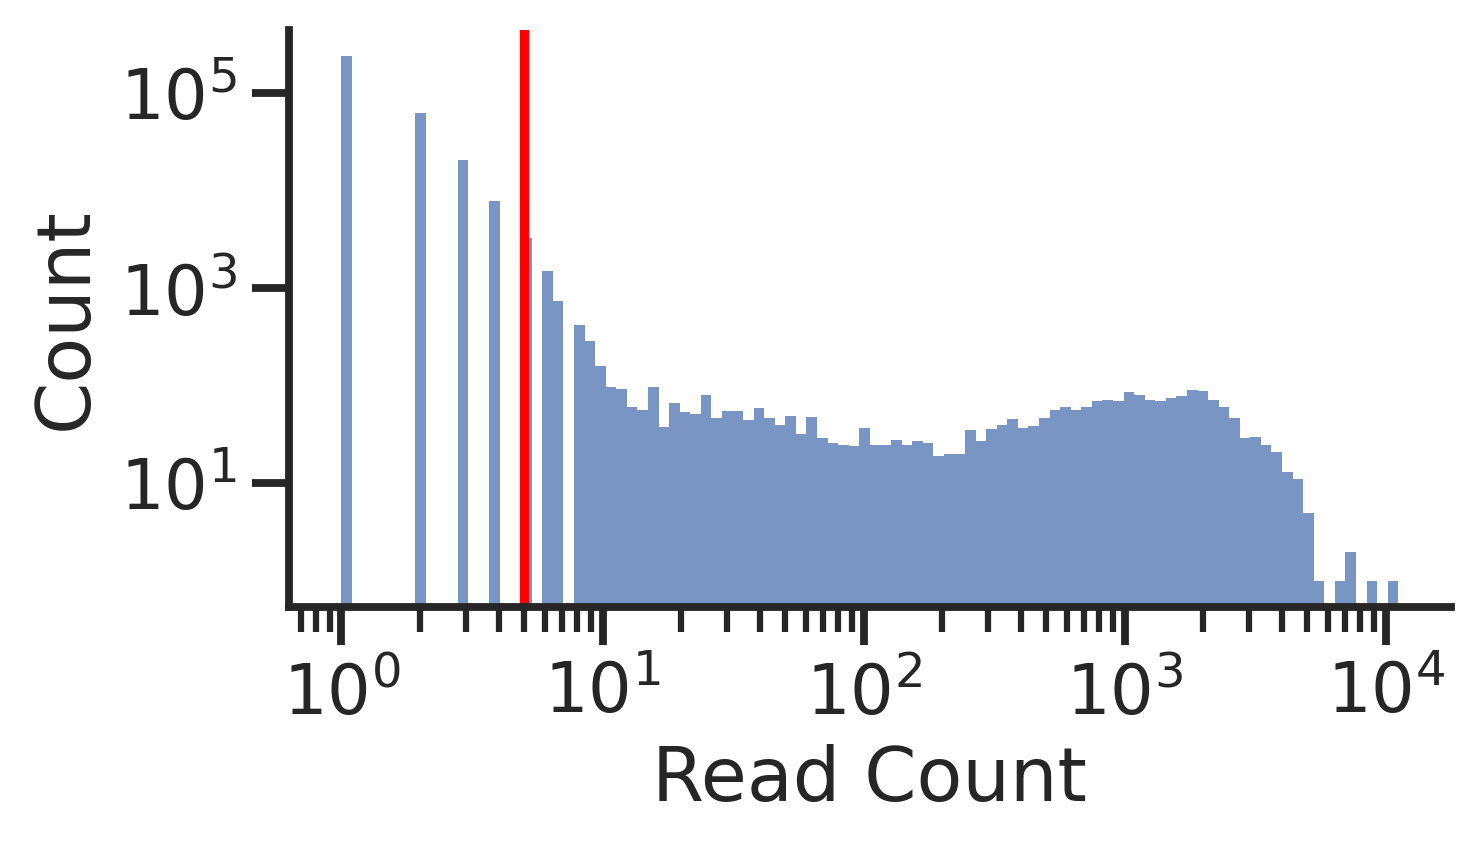

Done in 0.68 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_unique_target
Done in 0.03 seconds.


Filtering to designed sequences...
Created table: step1_ADBC2_HawkBCs_RTBC_AD_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.
Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_loss_summary'
Done in 0.09 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

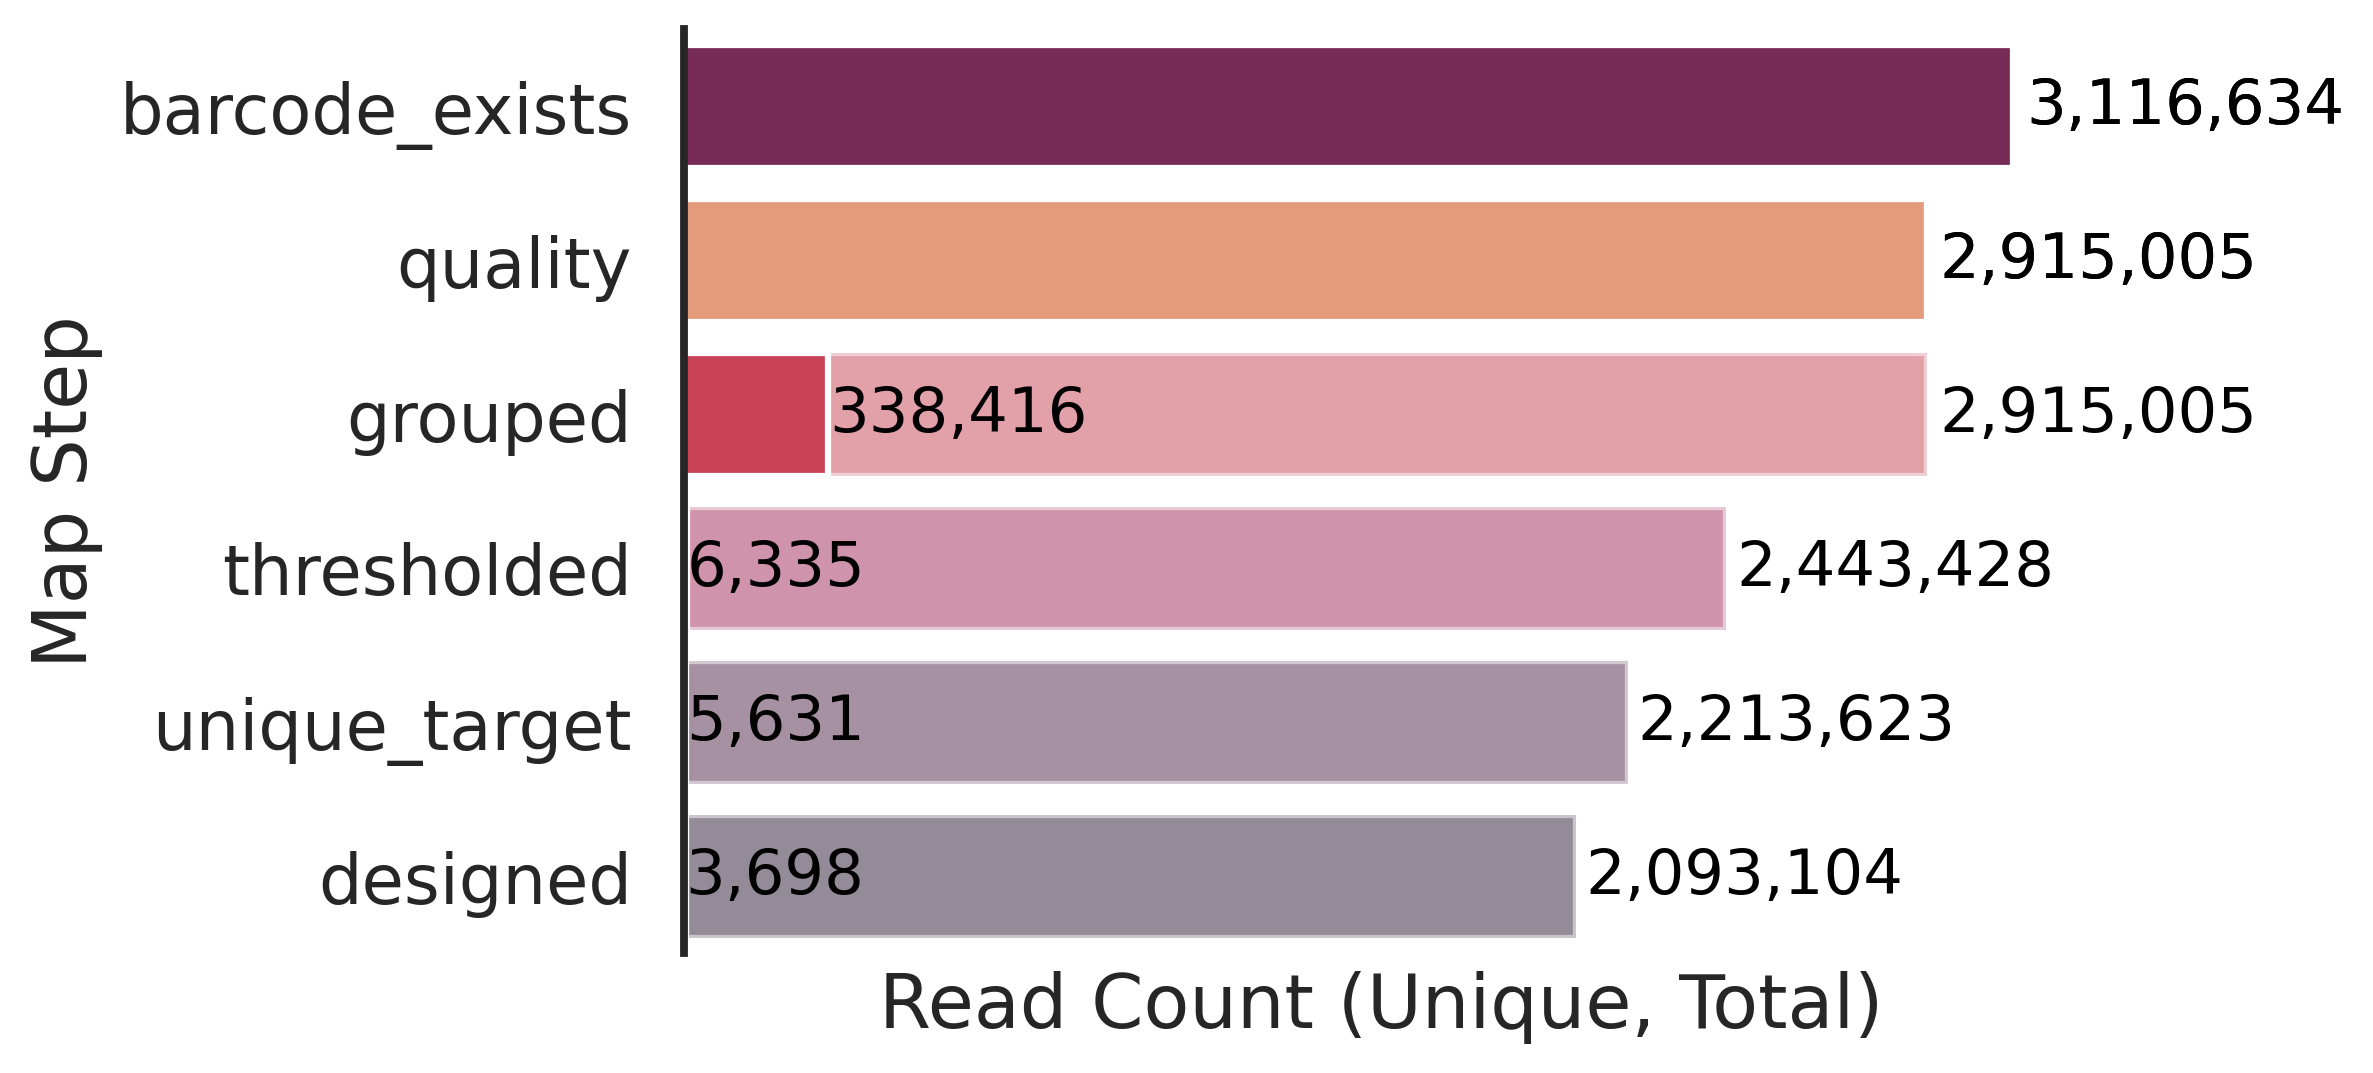

In [21]:
refiner_no_ec = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2-full.db",
                                    bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                    column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                                    design_check = True, 
                                    reads_threshold = 5,
                                    map_order = [
                                        "barcode_exists",
                                        "quality",
                                        "grouped",
                                        "thresholded",
                                        "unique_target",
                                        "designed"
                                    ],
                                    step_name = "step1",
                                 design_file = "../../data/DNA_Tiles_nkx2_2.txt",
                                        should_check_exists = False, 
                                         plot_histograms = True,
                                        min_fraction = 0.9,
                                        descriptor = "")
refiner_no_ec.refine_map_from_db()
refiner_no_ec.plot_loss()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_loss_summary'
Done in 0.08 seconds.



Text(0.5, 1.0, 'CC NKX2-2 Step 1:\nNo Error Correction')

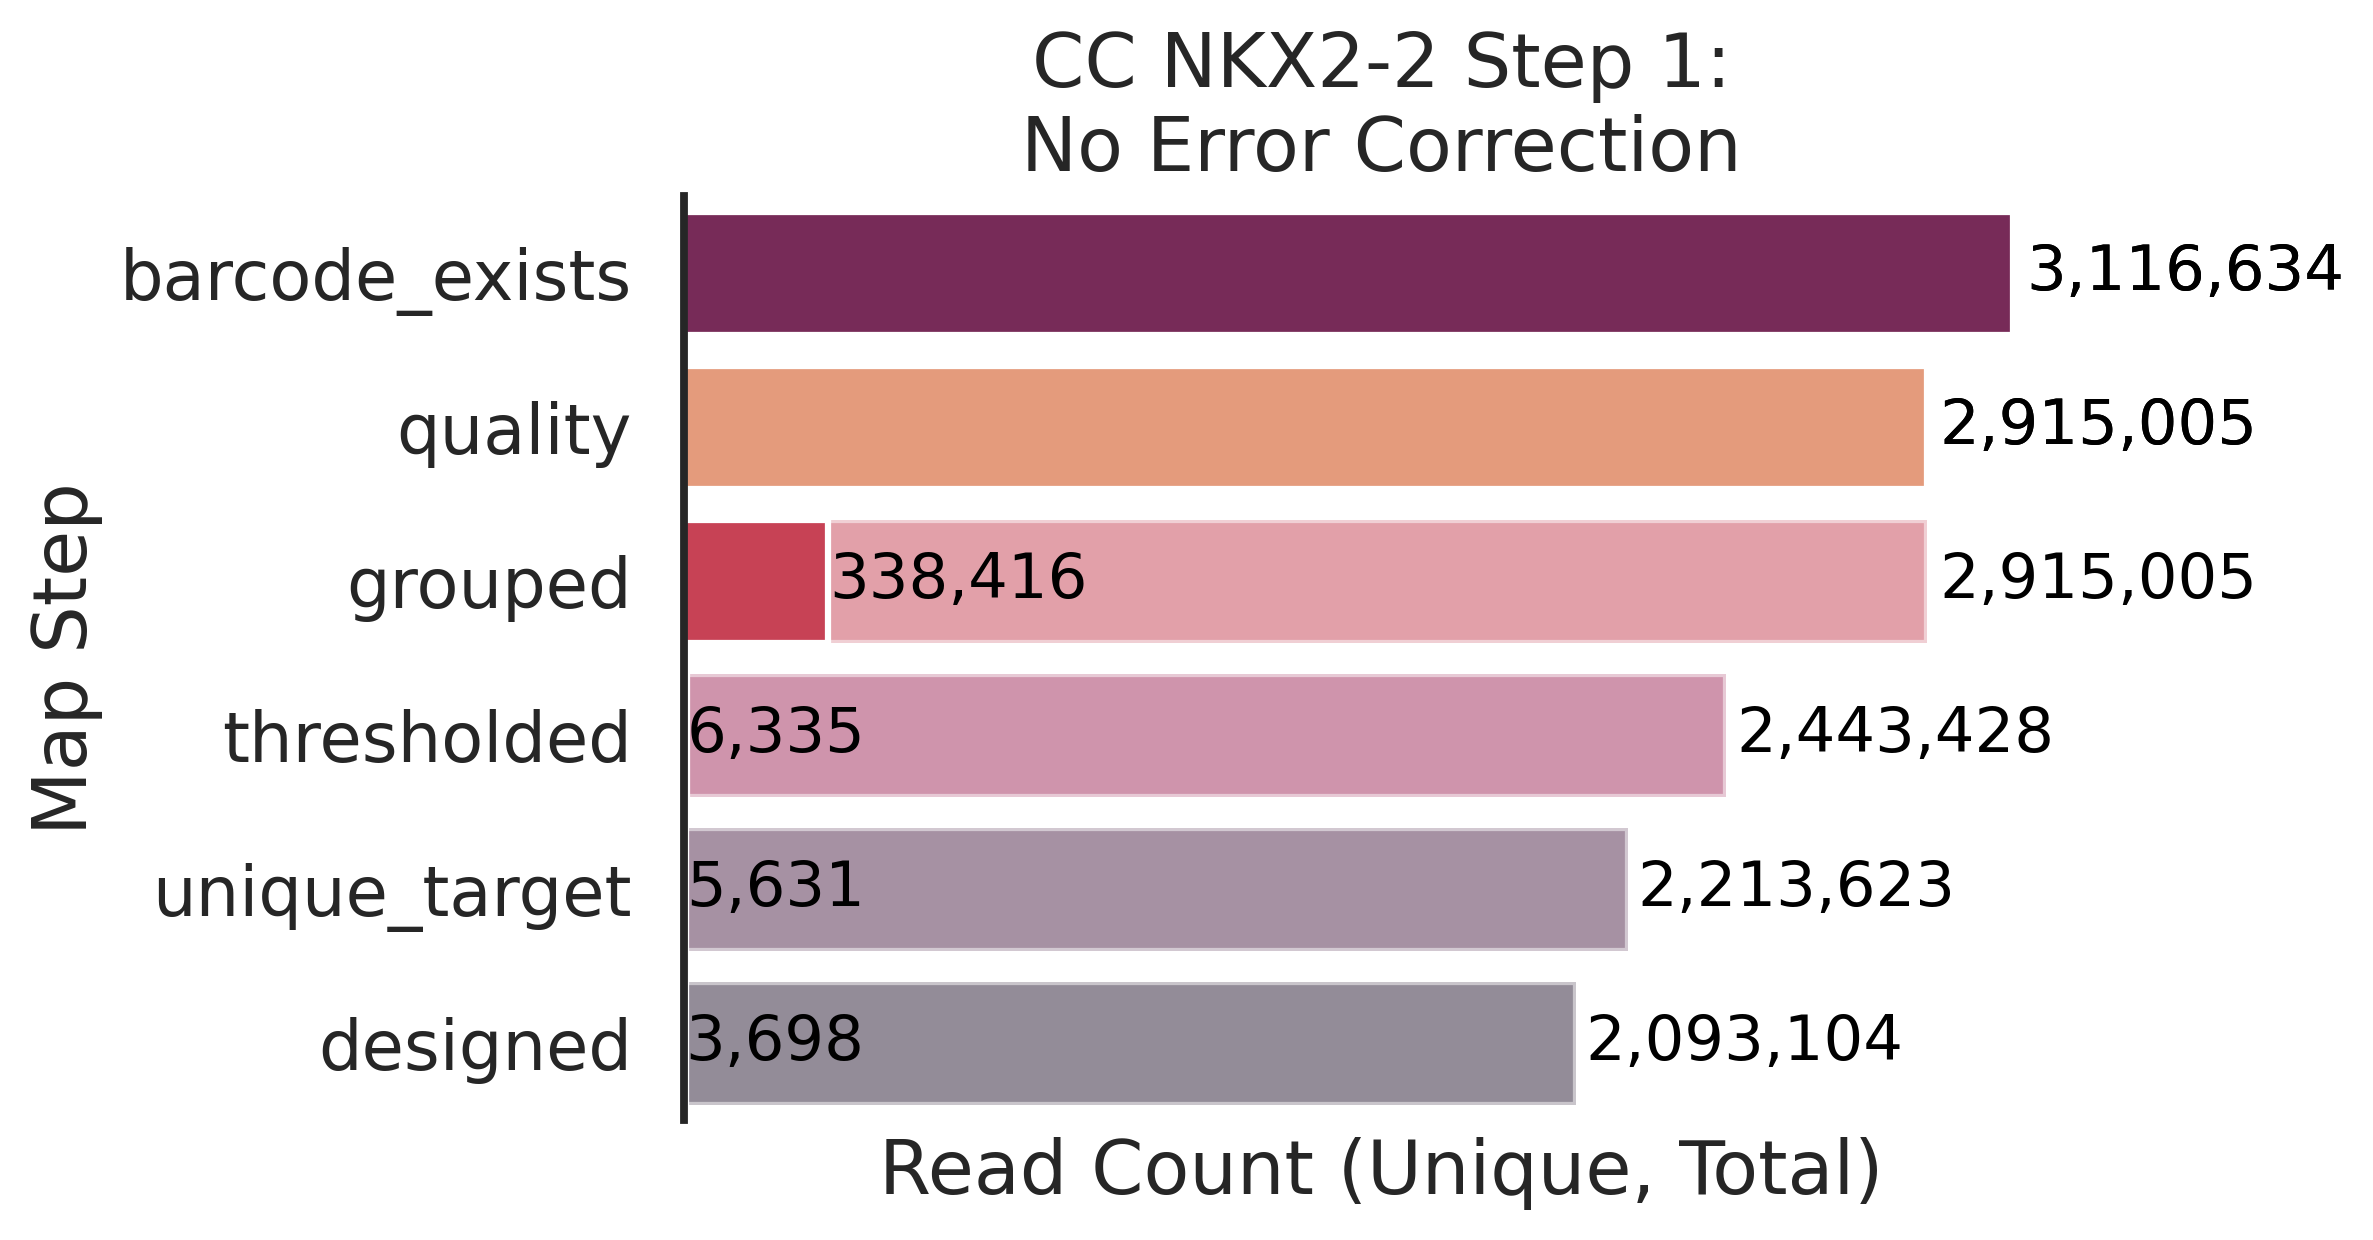

In [22]:
ax = refiner_no_ec.plot_loss()
ax.set_title("CC NKX2-2 Step 1:\nNo Error Correction")

In [31]:
grouped_no_error_correction = refiner_no_ec.get_map_df('grouped')
grouped_no_error_correction["concat"] = grouped_no_error_correction["ADBC2"] + grouped_no_error_correction["HawkBCs"] + grouped_no_error_correction["RTBC"] + grouped_no_error_correction["AD"]
grouped_no_error_correction

ADBC2    HawkBCs              RTBC  \
0       CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1       GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2       GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3       TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4       CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...        ...        ...               ...   
338411  AACTTG  ACATTGCCG  ACTACATTAATAATCC   
338412  TCTAAA  CAGCAATTC  ATTGGATTAGTTAAAA   
338413  AAGGCA  AGGGGAGTT  AGACTAAGTTGGATTA   
338414  ATTACA  AAGATTCCG  AATCAACGGTTCAATG   
338415  CATCTC  ATGCTCAGT  ACTCCAAGAAAAGGCA   

                                                       AD  count  ADBC2_qual  \
0       GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11172        True   
1       GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9261        True   
2       GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7239        True   
3       GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7042        True   
4       GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6387        True   
...                                                   ...    ...         ...   
338411  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...      1        True   
338412  GCCCAGGACCTGGCCGCCGCCGGCTTCCAGGCCGGCATTCCCTTCA...      1        True   
338413  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      1        True   
338414  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTGCCTTCA...      1        True   
338415  GCCCAGGACTTCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      1        True   

        HawkBCs_qual  RTBC_qual  AD_qual  Designed  \
0               True       True     True         1   
1               True       True     True         1   
2               True       True     True         1   
3               True       True     True         1   
4               True       True     True         1   
...              ...        ...      ...       ...   
338411          True       True     True         1   
338412          True       True     True         1   
338413          True       True     True         1   
338414          True       True     True         0   
338415          True       True     True         0   

                                                   concat  
0       CCATAACACCGATTGCAGCGTTTAACAAGCGGCCGGCGACCTGGCC...  
1       GTCAGCCCATTAACGTGTAAAATGGGGCTGGGACTCTCCCGGACCC...  
2       GTACAACCATCGGTTTTGCAGAATAGCTGCAGACTCTCCCGGACCC...  
3       TGGGACACCGGATGTCACAAAACGTGGCGCCGCCCAGGACCTGGCC...  
4       CTAATAATCAGGACCCAGGAAATCCCTCTATGCCCAGGACCTGGCC...  
...                                                   ...  
338411  AACTTGACATTGCCGACTACATTAATAATCCGCCCAGGACCTGGCC...  
338412  TCTAAACAGCAATTCATTGGATTAGTTAAAAGCCCAGGACCTGGCC...  
338413  AAGGCAAGGGGAGTTAGACTAAGTTGGATTAGCCCAGGACCTGGCC...  
338414  ATTACAAAGATTCCGAATCAACGGTTCAATGGCCCAGGACCTGGCC...  
338415  CATCTCATGCTCAGTACTCCAAGAAAAGGCAGCCCAGGACTTCGCC...  

[338416 rows x 11 columns]

In [32]:
HAR_AD_merged_expanded_density = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2_step1_figs/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt", sep = "\t", header = None)
HAR_AD_merged_expanded_density[1] = HAR_AD_merged_expanded_density[1].str.split(",")
HAR_AD_merged_expanded_density[3] = HAR_AD_merged_expanded_density[3].str.split(",")
HAR_AD_merged_expanded_density = HAR_AD_merged_expanded_density.explode([1,3])
HAR_AD_merged_expanded_density = HAR_AD_merged_expanded_density.rename(columns = {0: "canon_read", 1: "orig_read", 2 : "canon_read_count", 3 : "orig_read_count"})
HAR_AD_merged_expanded_density

canon_read  \
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
...                                                 ...   
1756  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
1756  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
1756  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
1756  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
1756  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   

                                              orig_read  canon_read_count  \
0     AAAAAAAACCACATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...               308   
0     AAAAAAAACCCCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...               308   
0     AAAAAAAACCGCATAGATAGTGGGATATAGAGCCCAGGACCTGGCC...               308   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...               308   
0     AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...               308   
...                                                 ...               ...   
1756  TTTTTTAGAGGAGTTTGATCGTAGGTGCATGGCCCAGGACCTTGCC...              2724   
1756  TTTTTTAGAGTAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...              2724   
1756  TTTTTTAGATGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...              2724   
1756  TTTTTTAGGGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...              2724   
1756  TTTTTTATAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...              2724   

     orig_read_count  
0                  1  
0                  2  
0                  1  
0                  1  
0                  1  
...              ...  
1756               1  
1756               1  
1756               2  
1756               1  
1756               8  

[105507 rows x 4 columns]

In [33]:
# Stack reads and counts
pt1 = HAR_AD_merged_expanded_density[['canon_read', 'canon_read_count']].rename(columns={'canon_read': 'concat', 'canon_read_count': 'count'}).drop_duplicates()
pt1["group"] = "real"
pt2 = HAR_AD_merged_expanded_density[['orig_read', 'orig_read_count']].rename(columns={'orig_read': 'concat', 'orig_read_count': 'count'})
pt2["group"] = "merged_error"
                                                                              
HAR_AD_merged_expanded_density_reads = pd.concat([
    pt1,
    pt2
], ignore_index=True)

# Ensure counts are numeric
HAR_AD_merged_expanded_density_reads['count'] = HAR_AD_merged_expanded_density_reads['count'].astype(int)
HAR_AD_merged_expanded_density_reads

concat  count         group
0       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...    308          real
1       AAAAAAACTCTTGCACTAATTGAATAAGTATGCCCAGGACCTGGCC...    781          real
2       AAAAAAATTCTCGCCCTGGAATGACATAGGGGCCCAGGACCTGGCC...   1232          real
3       AAAAATAAGATTCCGAATGACTTGCATTAGGGCCCAGGACCTGGCC...    314          real
4       AAAAATATACCGTCGTATTATGACACACTTAGCCCAGGACCTGGCC...    729          real
...                                                   ...    ...           ...
107259  TTTTTTAGAGGAGTTTGATCGTAGGTGCATGGCCCAGGACCTTGCC...      1  merged_error
107260  TTTTTTAGAGTAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...      1  merged_error
107261  TTTTTTAGATGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...      2  merged_error
107262  TTTTTTAGGGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...      1  merged_error
107263  TTTTTTATAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...      8  merged_error

[107264 rows x 3 columns]

In [34]:
# 2.5 mill reads (most reads saved!) of 2.9
sum(HAR_AD_merged_expanded_density_reads["count"])

2509548

In [35]:
# HAR_AD_merged_expanded_density_reads["AD"] = HAR_AD_merged_expanded_density_reads["read"].str[:162]
# HAR_AD_merged_expanded_density_reads["HawkBCs"] = HAR_AD_merged_expanded_density_reads["read"].str[162: 162 + 9]
# HAR_AD_merged_expanded_density_reads["ADBC2"] = HAR_AD_merged_expanded_density_reads["read"].str[ 162 + 9: 162 + 15]
# HAR_AD_merged_expanded_density_reads["RTBC"] = HAR_AD_merged_expanded_density_reads["read"].str[ 162 + 15:]
# HAR_AD_merged_expanded_density_reads

In [38]:
raw_grouped_HAR_AD_merged_expanded_density_reads = pd.merge(grouped_no_error_correction, HAR_AD_merged_expanded_density_reads, how = 'left', on = "concat")
#raw_grouped_HAR_AD_merged_expanded_density_reads["whitelisted"] = ~raw_grouped_HAR_AD_merged_expanded_density_reads["read"].isna()
#raw_grouped_HAR_AD_merged_expanded_reads = raw_grouped_HAR_AD_merged_expanded_reads.sort_values(by = 'count', ascending= False)
raw_grouped_HAR_AD_merged_expanded_density_reads["group"] = raw_grouped_HAR_AD_merged_expanded_density_reads["group"].fillna("discarded")
raw_grouped_HAR_AD_merged_expanded_density_reads

ADBC2    HawkBCs              RTBC  \
0       CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1       GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2       GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3       TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4       CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...        ...        ...               ...   
338411  AACTTG  ACATTGCCG  ACTACATTAATAATCC   
338412  TCTAAA  CAGCAATTC  ATTGGATTAGTTAAAA   
338413  AAGGCA  AGGGGAGTT  AGACTAAGTTGGATTA   
338414  ATTACA  AAGATTCCG  AATCAACGGTTCAATG   
338415  CATCTC  ATGCTCAGT  ACTCCAAGAAAAGGCA   

                                                       AD  count_x  \
0       GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...    11172   
1       GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...     9261   
2       GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...     7239   
3       GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     7042   
4       GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     6387   
...                                                   ...      ...   
338411  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...        1   
338412  GCCCAGGACCTGGCCGCCGCCGGCTTCCAGGCCGGCATTCCCTTCA...        1   
338413  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...        1   
338414  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTGCCTTCA...        1   
338415  GCCCAGGACTTCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...        1   

        ADBC2_qual  HawkBCs_qual  RTBC_qual  AD_qual  Designed  \
0             True          True       True     True         1   
1             True          True       True     True         1   
2             True          True       True     True         1   
3             True          True       True     True         1   
4             True          True       True     True         1   
...            ...           ...        ...      ...       ...   
338411        True          True       True     True         1   
338412        True          True       True     True         1   
338413        True          True       True     True         1   
338414        True          True       True     True         0   
338415        True          True       True     True         0   

                                                   concat  count_y  \
0       CCATAACACCGATTGCAGCGTTTAACAAGCGGCCGGCGACCTGGCC...  11172.0   
1       GTCAGCCCATTAACGTGTAAAATGGGGCTGGGACTCTCCCGGACCC...   9261.0   
2       GTACAACCATCGGTTTTGCAGAATAGCTGCAGACTCTCCCGGACCC...   7239.0   
3       TGGGACACCGGATGTCACAAAACGTGGCGCCGCCCAGGACCTGGCC...   7042.0   
4       CTAATAATCAGGACCCAGGAAATCCCTCTATGCCCAGGACCTGGCC...   6387.0   
...                                                   ...      ...   
338411  AACTTGACATTGCCGACTACATTAATAATCCGCCCAGGACCTGGCC...      NaN   
338412  TCTAAACAGCAATTCATTGGATTAGTTAAAAGCCCAGGACCTGGCC...      1.0   
338413  AAGGCAAGGGGAGTTAGACTAAGTTGGATTAGCCCAGGACCTGGCC...      1.0   
338414  ATTACAAAGATTCCGAATCAACGGTTCAATGGCCCAGGACCTGGCC...      NaN   
338415  CATCTCATGCTCAGTACTCCAAGAAAAGGCAGCCCAGGACTTCGCC...      NaN   

               group  
0               real  
1               real  
2               real  
3               real  
4               real  
...              ...  
338411     discarded  
338412  merged_error  
338413  merged_error  
338414     discarded  
338415     discarded  

[338416 rows x 13 columns]

In [41]:
# Filter data: remove zeros, negatives, and infinities
data1 = grouped_no_error_correction["count"]
data2 = raw_grouped_HAR_AD_merged_expanded_density_reads["count_x"]

data1 = data1[(data1 > 0) & np.isfinite(data1)]
data2 = data2[(data2 > 0) & np.isfinite(data2)]

# Determine min and max across filtered data
min_val = min(data1.min(), data2.min())
max_val = max(data1.max(), data2.max())

# If max_val is extremely large, clip to avoid overflow in logspace
max_val = min(max_val, 1e12)  # adjust 1e12 as needed

# Define log-spaced bins
bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)
bins

array([1.00000000e+00, 1.09872805e+00, 1.20720332e+00, 1.32638815e+00,
       1.45733987e+00, 1.60122019e+00, 1.75930553e+00, 1.93299833e+00,
       2.12383949e+00, 2.33352201e+00, 2.56390609e+00, 2.81703553e+00,
       3.09515595e+00, 3.40073466e+00, 3.73648256e+00, 4.10537819e+00,
       4.51069417e+00, 4.95602620e+00, 5.44532499e+00, 5.98293130e+00,
       6.57361444e+00, 7.22261456e+00, 7.93568920e+00, 8.71916431e+00,
       9.57999039e+00, 1.05258041e+01, 1.15649962e+01, 1.27067858e+01,
       1.39613019e+01, 1.53396740e+01, 1.68541301e+01, 1.85181055e+01,
       2.03463619e+01, 2.23551185e+01, 2.45621957e+01, 2.69871733e+01,
       2.96515643e+01, 3.25790054e+01, 3.57954670e+01, 3.93294836e+01,
       4.32124067e+01, 4.74786833e+01, 5.21661611e+01, 5.73164244e+01,
       6.29751631e+01, 6.91925780e+01, 7.60238262e+01, 8.35295102e+01,
       9.17762158e+01, 1.00837102e+02, 1.10792553e+02, 1.21730885e+02,
       1.33749138e+02, 1.46953929e+02, 1.61462404e+02, 1.77403272e+02,
      

Text(0.5, 0, 'Concat Count')

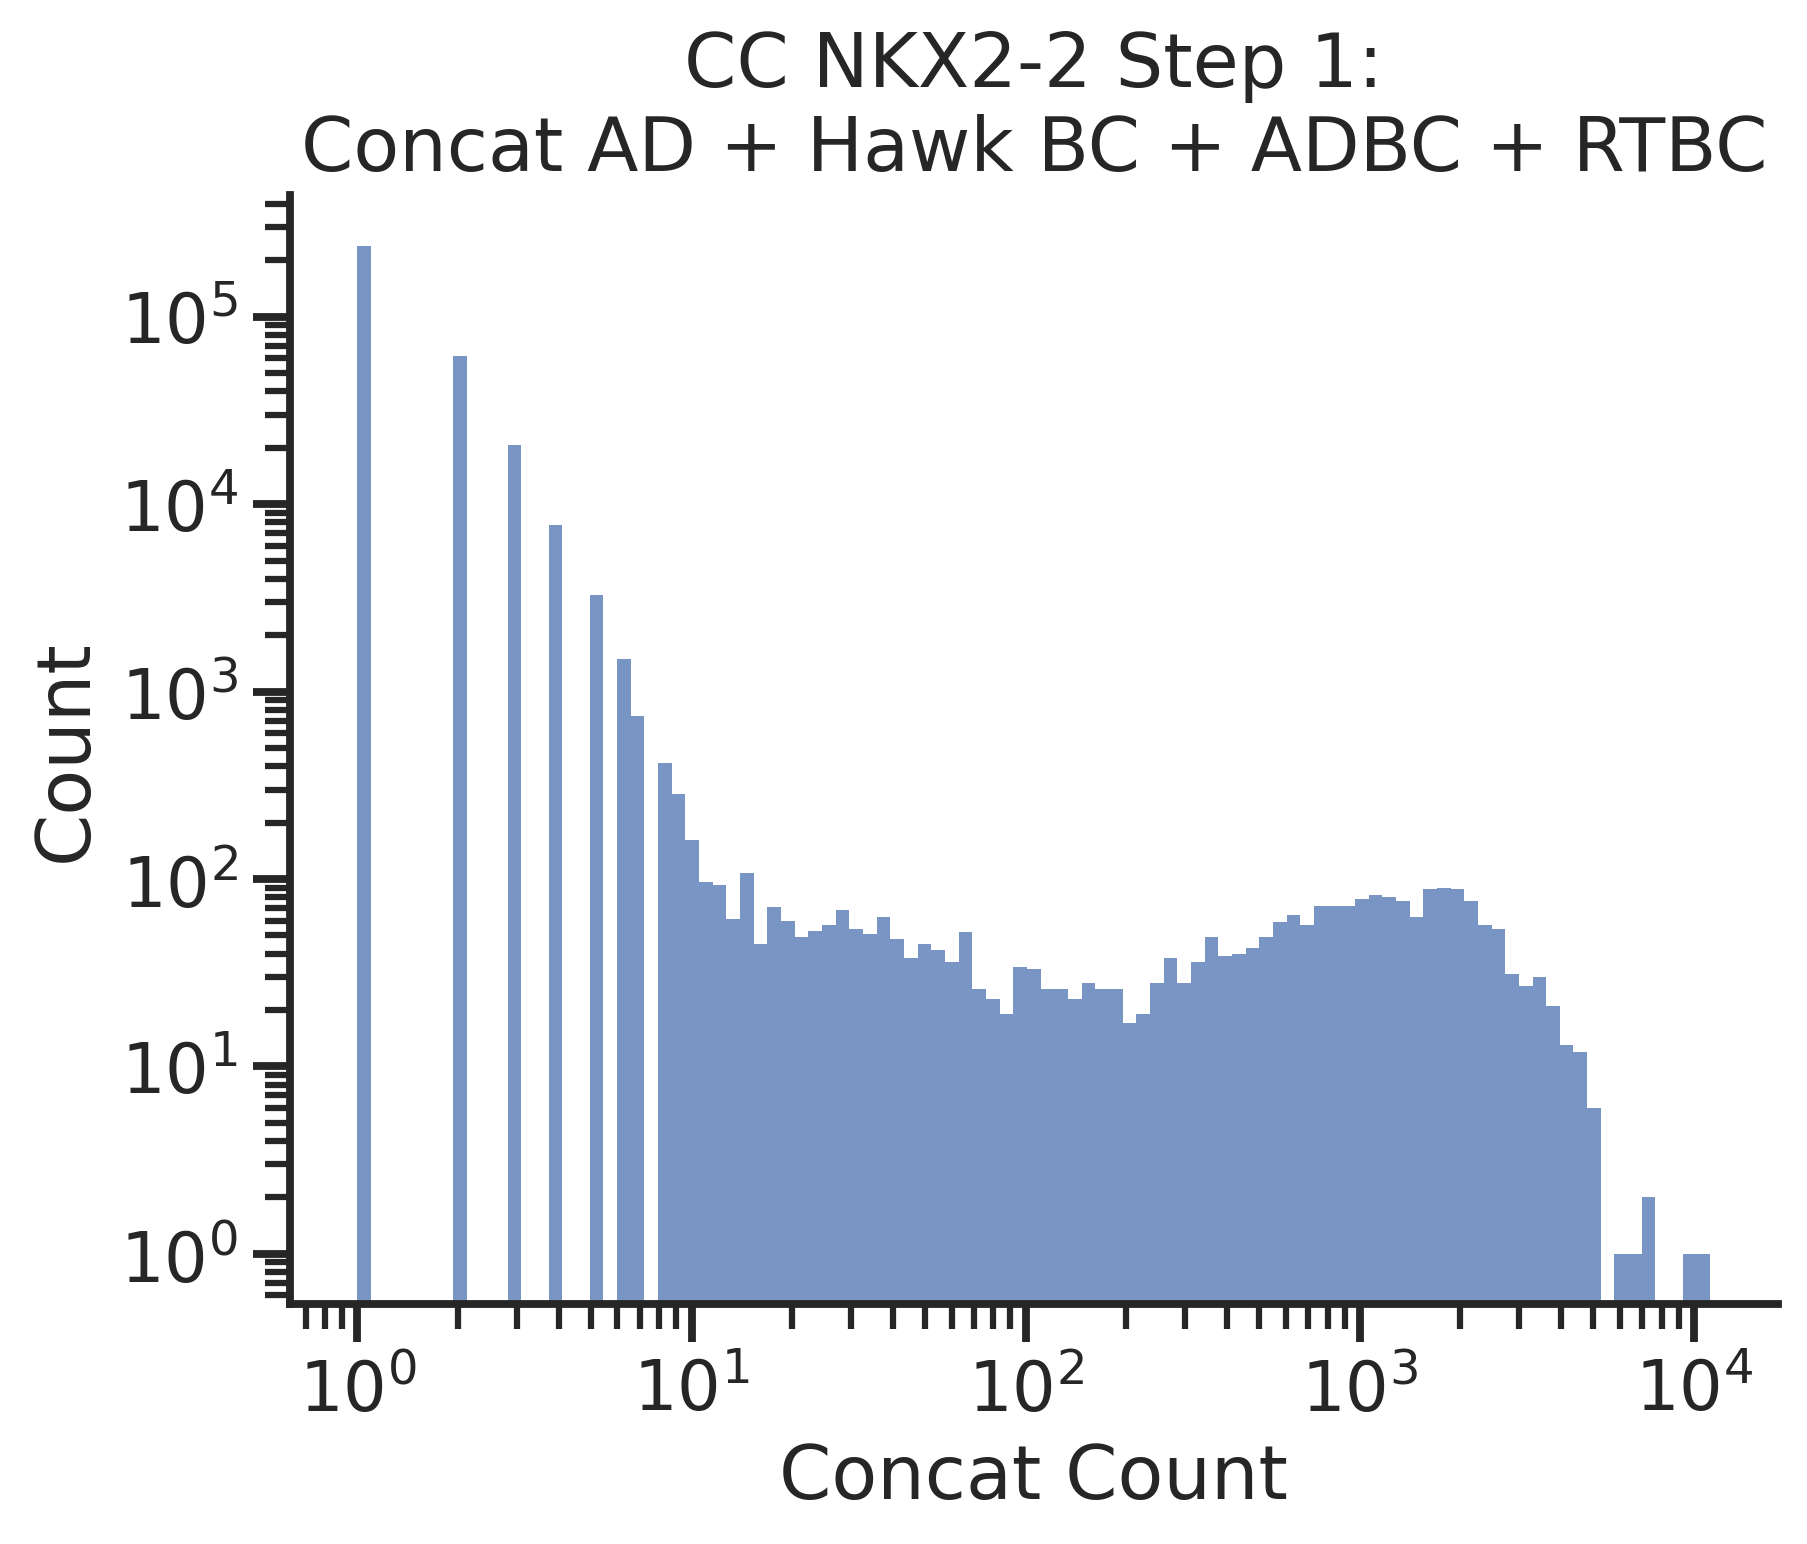

In [48]:
palette = sns.color_palette('colorblind')
palette

sns.set_style('ticks')

sns.set_context('talk')
plt.figure(dpi = 300)
ax = sns.histplot(data = raw_grouped_HAR_AD_merged_expanded_density_reads, 
                  x = "count_x", 
                  log_scale=(False, False), 
                  bins = bins, 
                  multiple = 'layer',
                 palette = {"real" : palette[3], "discarded" : palette[1], "merged_error" : palette[2]})
#sns.histplot(HAR_AD_merged["new_total_count"], log_scale = (False, True), ax = ax, bins = bins, label = "After Whitelisting")
#ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("CC NKX2-2 Step 1:\nConcat AD + Hawk BC + ADBC + RTBC")
sns.despine()
ax.set_xlabel("Concat Count")

#ax.set_xlim(1, None)

Text(0.5, 0, 'Concat Count')

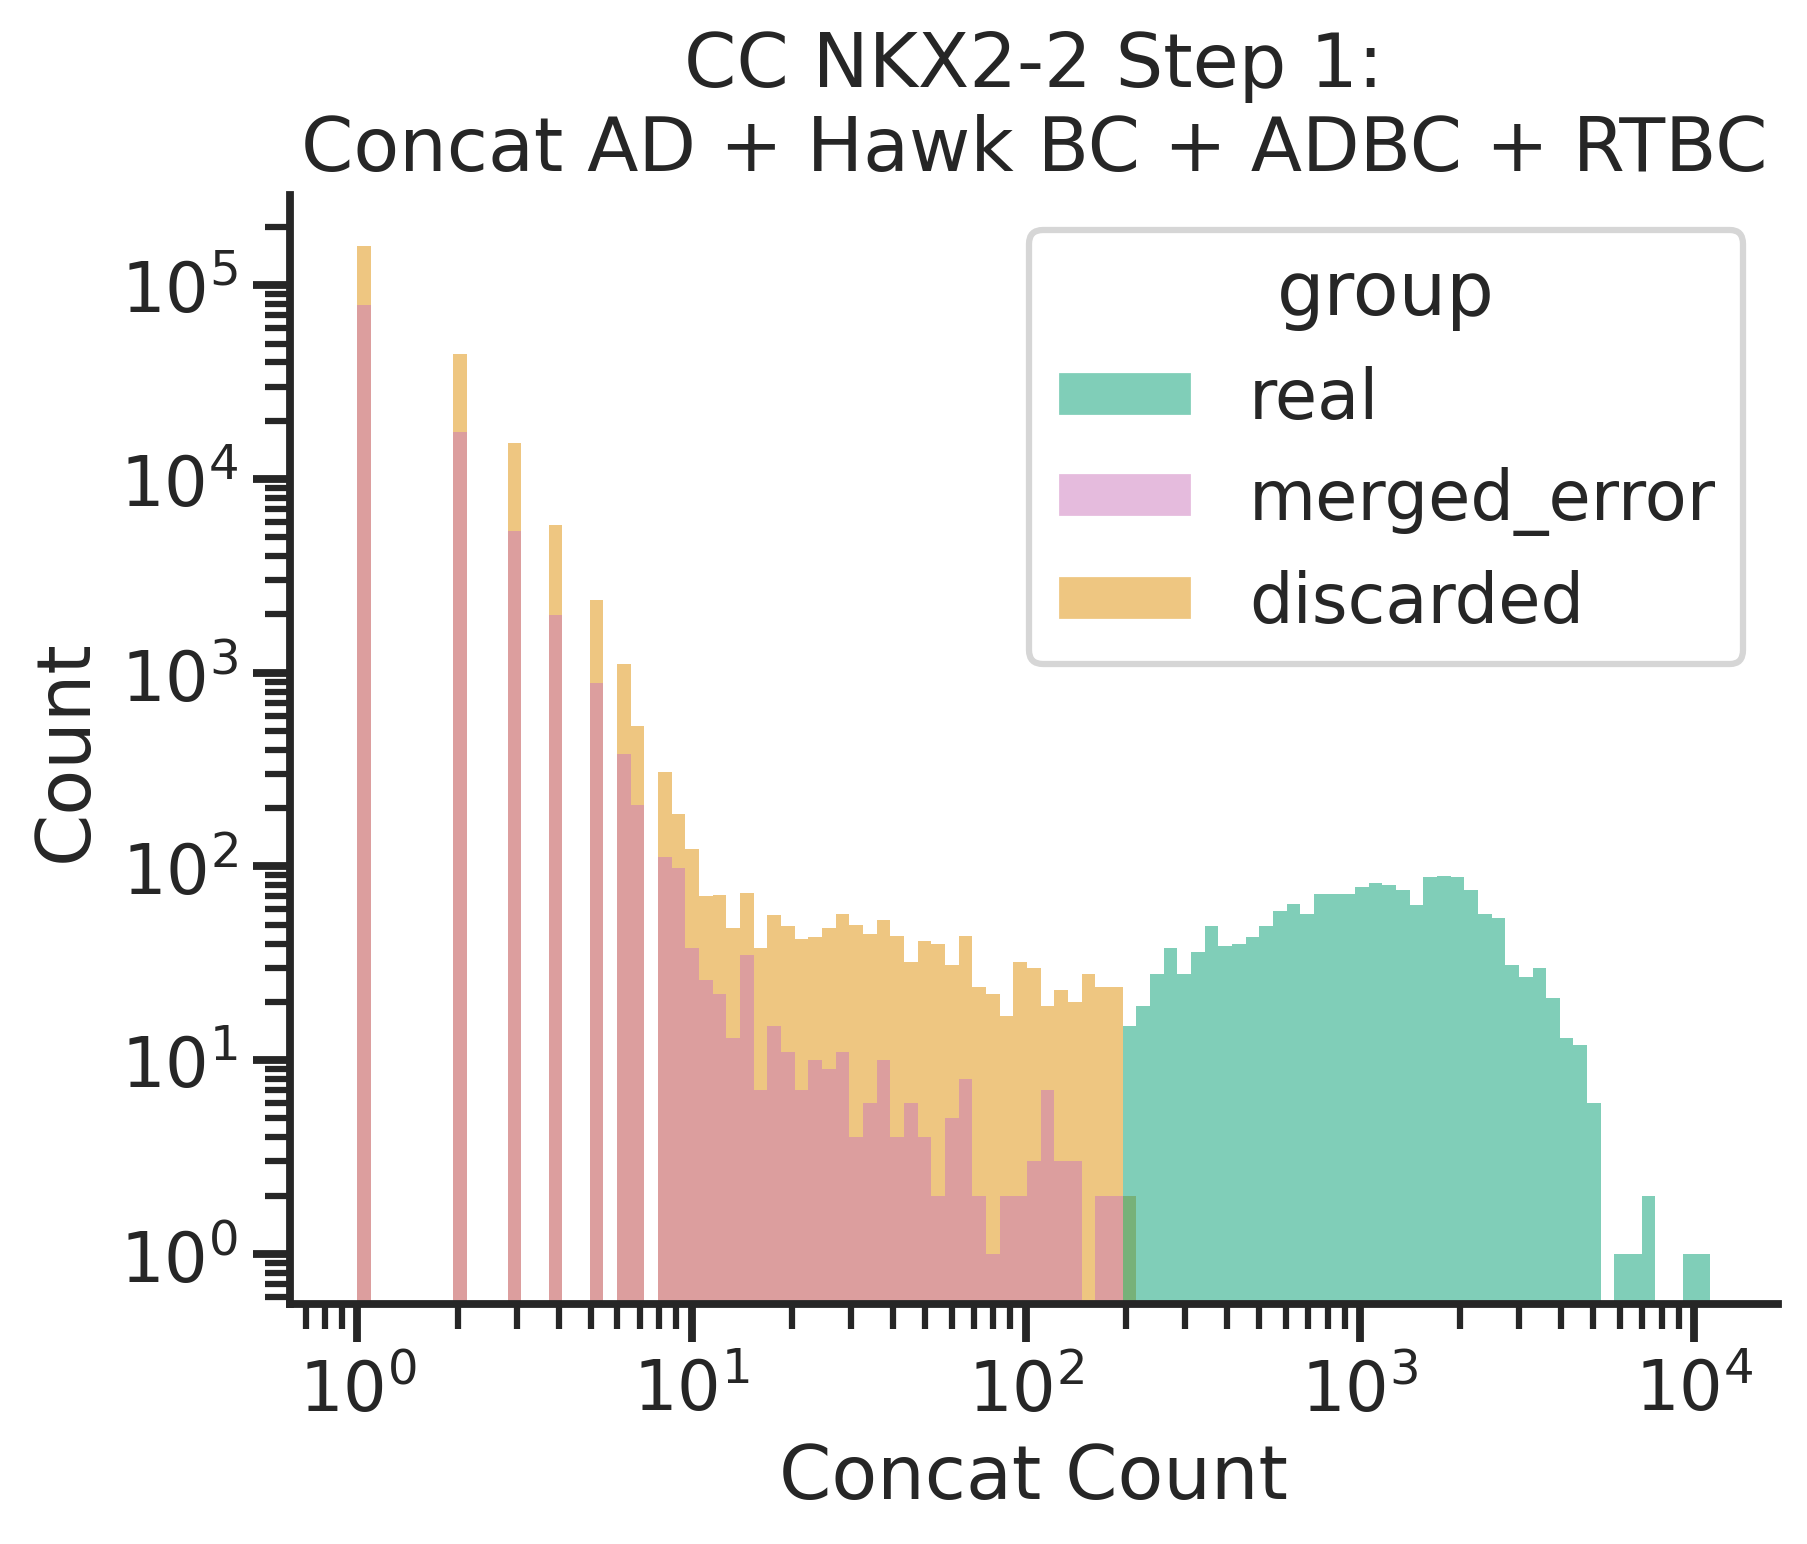

In [49]:
sns.set_context('talk')
plt.figure(dpi = 300)
ax = sns.histplot(data = raw_grouped_HAR_AD_merged_expanded_density_reads, 
                  x = "count_x", 
                  hue = "group",
                  log_scale=(False, False), 
                  bins = bins, 
                hue_order=["real", "merged_error", "discarded"],  
                  multiple = 'layer',
                 palette = {"real" : palette[2], "discarded" : palette[1], "merged_error" : palette[4]})
#sns.histplot(HAR_AD_merged["new_total_count"], log_scale = (False, True), ax = ax, bins = bins, label = "After Whitelisting")
#ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("CC NKX2-2 Step 1:\nConcat AD + Hawk BC + ADBC + RTBC")
sns.despine()
ax.set_xlabel("Concat Count")

#ax.set_xlim(1, None)

In [19]:
grouped_error_correction = refiner.get_map_df('grouped')
grouped_error_correction

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
1752  GGGTAA  AGAGCAATG  AGTACCAAGATCAGTA   
1753  ATAAAT  CCATTCTGC  ATTATATGGTTGATAT   
1754  GGGTTT  AACAGAGTC  AGGTTGCCAAGCACCG   
1755  GCATTG  ATAGTCCGC  CGACAGGTTTTAAACT   
1756  AGGGAG  AATGAGAGG  CTTGATAGGGCTGGGC   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11926        True   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9765        True   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7668        True   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7590        True   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6817        True   
...                                                 ...    ...         ...   
1752  GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCGGCATTCCCTTCA...    217        True   
1753  CCTACCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...    216        True   
1754  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...    213        True   
1755  GCCGCCGACCTGGCCGCCGCCACCTTCGCCGCCGGCATTCCCTTCA...    210        True   
1756  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...    210        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  
0             True       True     True         1  
1             True       True     True         1  
2             True       True     True         1  
3             True       True     True         1  
4             True       True     True         1  
...            ...        ...      ...       ...  
1752          True       True     True         1  
1753          True       True     True         0  
1754          True       True     True         1  
1755          True       True     True         1  
1756          True       True     True         1  

[1757 rows x 10 columns]

In [24]:
pd.merge(grouped_no_error_correction, grouped_error_correction, on = ["ADBC2", "HawkBCs", "RTBC", "AD"])

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
1752  CGAAAA  ACGCCTGAA  ATAAAAATAATTAATT   
1753  GCATTG  ATAGTCCGC  CGACAGGTTTTAAACT   
1754  AGGGAG  AATGAGAGG  CTTGATAGGGCTGGGC   
1755  TAAACA  ACCTAATGG  CATTACTGCTTGATTT   
1756  GGGTTT  AACAGAGTC  AGGTTGCCAAGCACCG   

                                                     AD  count_x  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...    11172   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...     9261   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...     7239   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     7042   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     6387   
...                                                 ...      ...   
1752  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      203   
1753  GCCGCCGACCTGGCCGCCGCCACCTTCGCCGCCGGCATTCCCTTCA...      200   
1754  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      199   
1755  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      198   
1756  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      198   

      ADBC2_qual_x  HawkBCs_qual_x  RTBC_qual_x  AD_qual_x  Designed_x  \
0             True            True         True       True           1   
1             True            True         True       True           1   
2             True            True         True       True           1   
3             True            True         True       True           1   
4             True            True         True       True           1   
...            ...             ...          ...        ...         ...   
1752          True            True         True       True           1   
1753          True            True         True       True           1   
1754          True            True         True       True           1   
1755          True            True         True       True           1   
1756          True            True         True       True           1   

      count_y  ADBC2_qual_y  HawkBCs_qual_y  RTBC_qual_y  AD_qual_y  \
0       11926          True            True         True       True   
1        9765          True            True         True       True   
2        7668          True            True         True       True   
3        7590          True            True         True       True   
4        6817          True            True         True       True   
...       ...           ...             ...          ...        ...   
1752      217          True            True         True       True   
1753      210          True            True         True       True   
1754      210          True            True         True       True   
1755      253          True            True         True       True   
1756      213          True            True         True       True   

      Designed_y  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
1752           1  
1753           1  
1754           1  
1755           1  
1756           1  

[1757 rows x 16 columns]

In [9]:
# mapper.apply_whitelist("../../data/NKX2-2_whitelist_test_function/")

In [10]:
# error_correct.run_whitelist_concat_domains("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq",
#                                            "../../data/NKX2-2_whitelist_test_function/")

In [11]:
# error_correct.convert_txt_to_whitelist_mapping_df_from_path('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt')

# Old

In [6]:
error_correct.run_whitelist_parallel( barcodes = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                     input_fastq = '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq',
                                     output_dir = "../../data/NKX2-2_whitelist_test_function")

Done in 0.00 seconds.

Generating whitelist for ADBC2...
Generating whitelist for HawkBCs...
Generating whitelist for RTBC...
Generating whitelist for AD...
Done in 3.59 minutes.

Whitelist generated for ADBC2 at ../../data/NKX2-2_whitelist_test_function/ADBC2_whitelist.txt
Done in 3.64 minutes.

Whitelist generated for AD at ../../data/NKX2-2_whitelist_test_function/AD_whitelist.txt
Done in 3.82 minutes.

Whitelist generated for RTBC at ../../data/NKX2-2_whitelist_test_function/RTBC_whitelist.txt
Done in 3.97 minutes.

Whitelist generated for HawkBCs at ../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt


['Whitelist generated for ADBC2 at ../../data/NKX2-2_whitelist_test_function/ADBC2_whitelist.txt',
 'Whitelist generated for AD at ../../data/NKX2-2_whitelist_test_function/AD_whitelist.txt',
 'Whitelist generated for RTBC at ../../data/NKX2-2_whitelist_test_function/RTBC_whitelist.txt',
 'Whitelist generated for HawkBCs at ../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt']

In [9]:
error_correct.convert_txt_to_whitelist_mapping_df(step1_HawkBCs,
                                     output_dir = "../../data/NKX2-2_whitelist_test_function")

original  canonical
0     AACAACACC  AACAACACC
1     AAAAACACC  AACAACACC
2     AACAAAACC  AACAACACC
3     AACAACAAC  AACAACACC
4     AACAACACA  AACAACACC
...         ...        ...
4118  CCGTTCAGG  CCGTTCAGA
4119  CCGTTCATA  CCGTTCAGA
4120  CCGTTCGGA  CCGTTCAGA
4121  CCTTTCAGA  CCGTTCAGA
4122  TCGTTCAGA  CCGTTCAGA

[4123 rows x 2 columns]

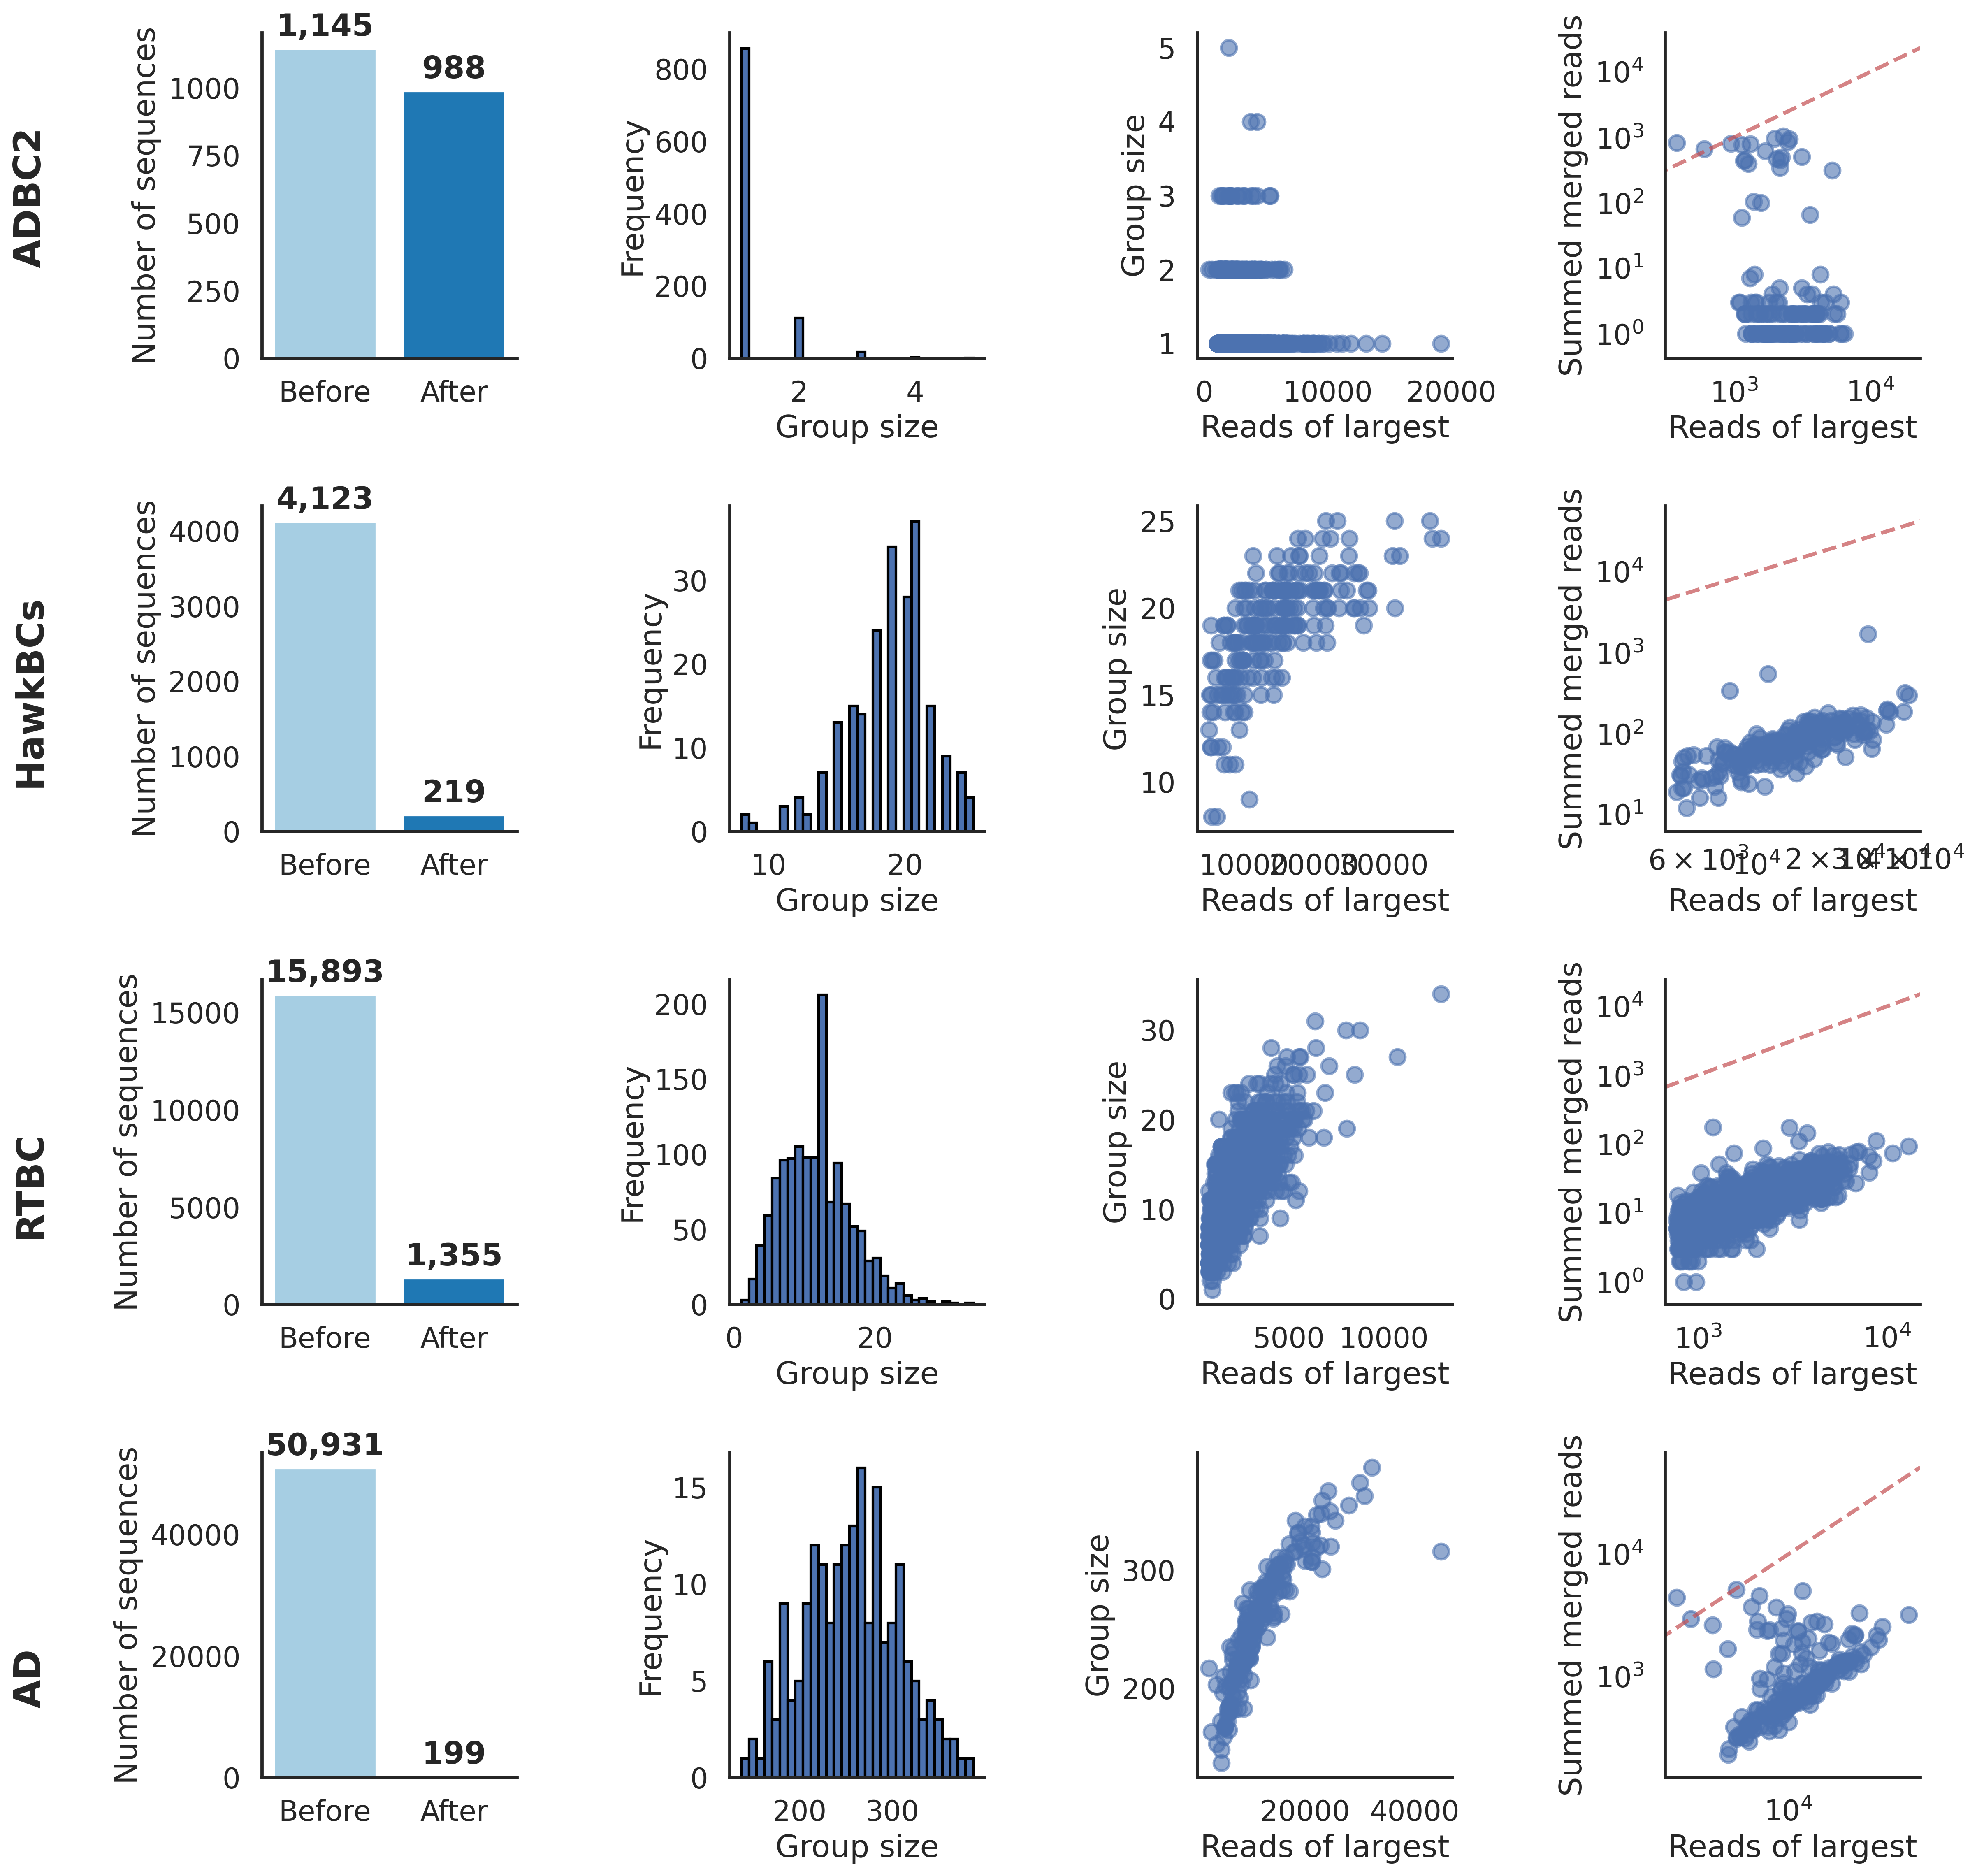

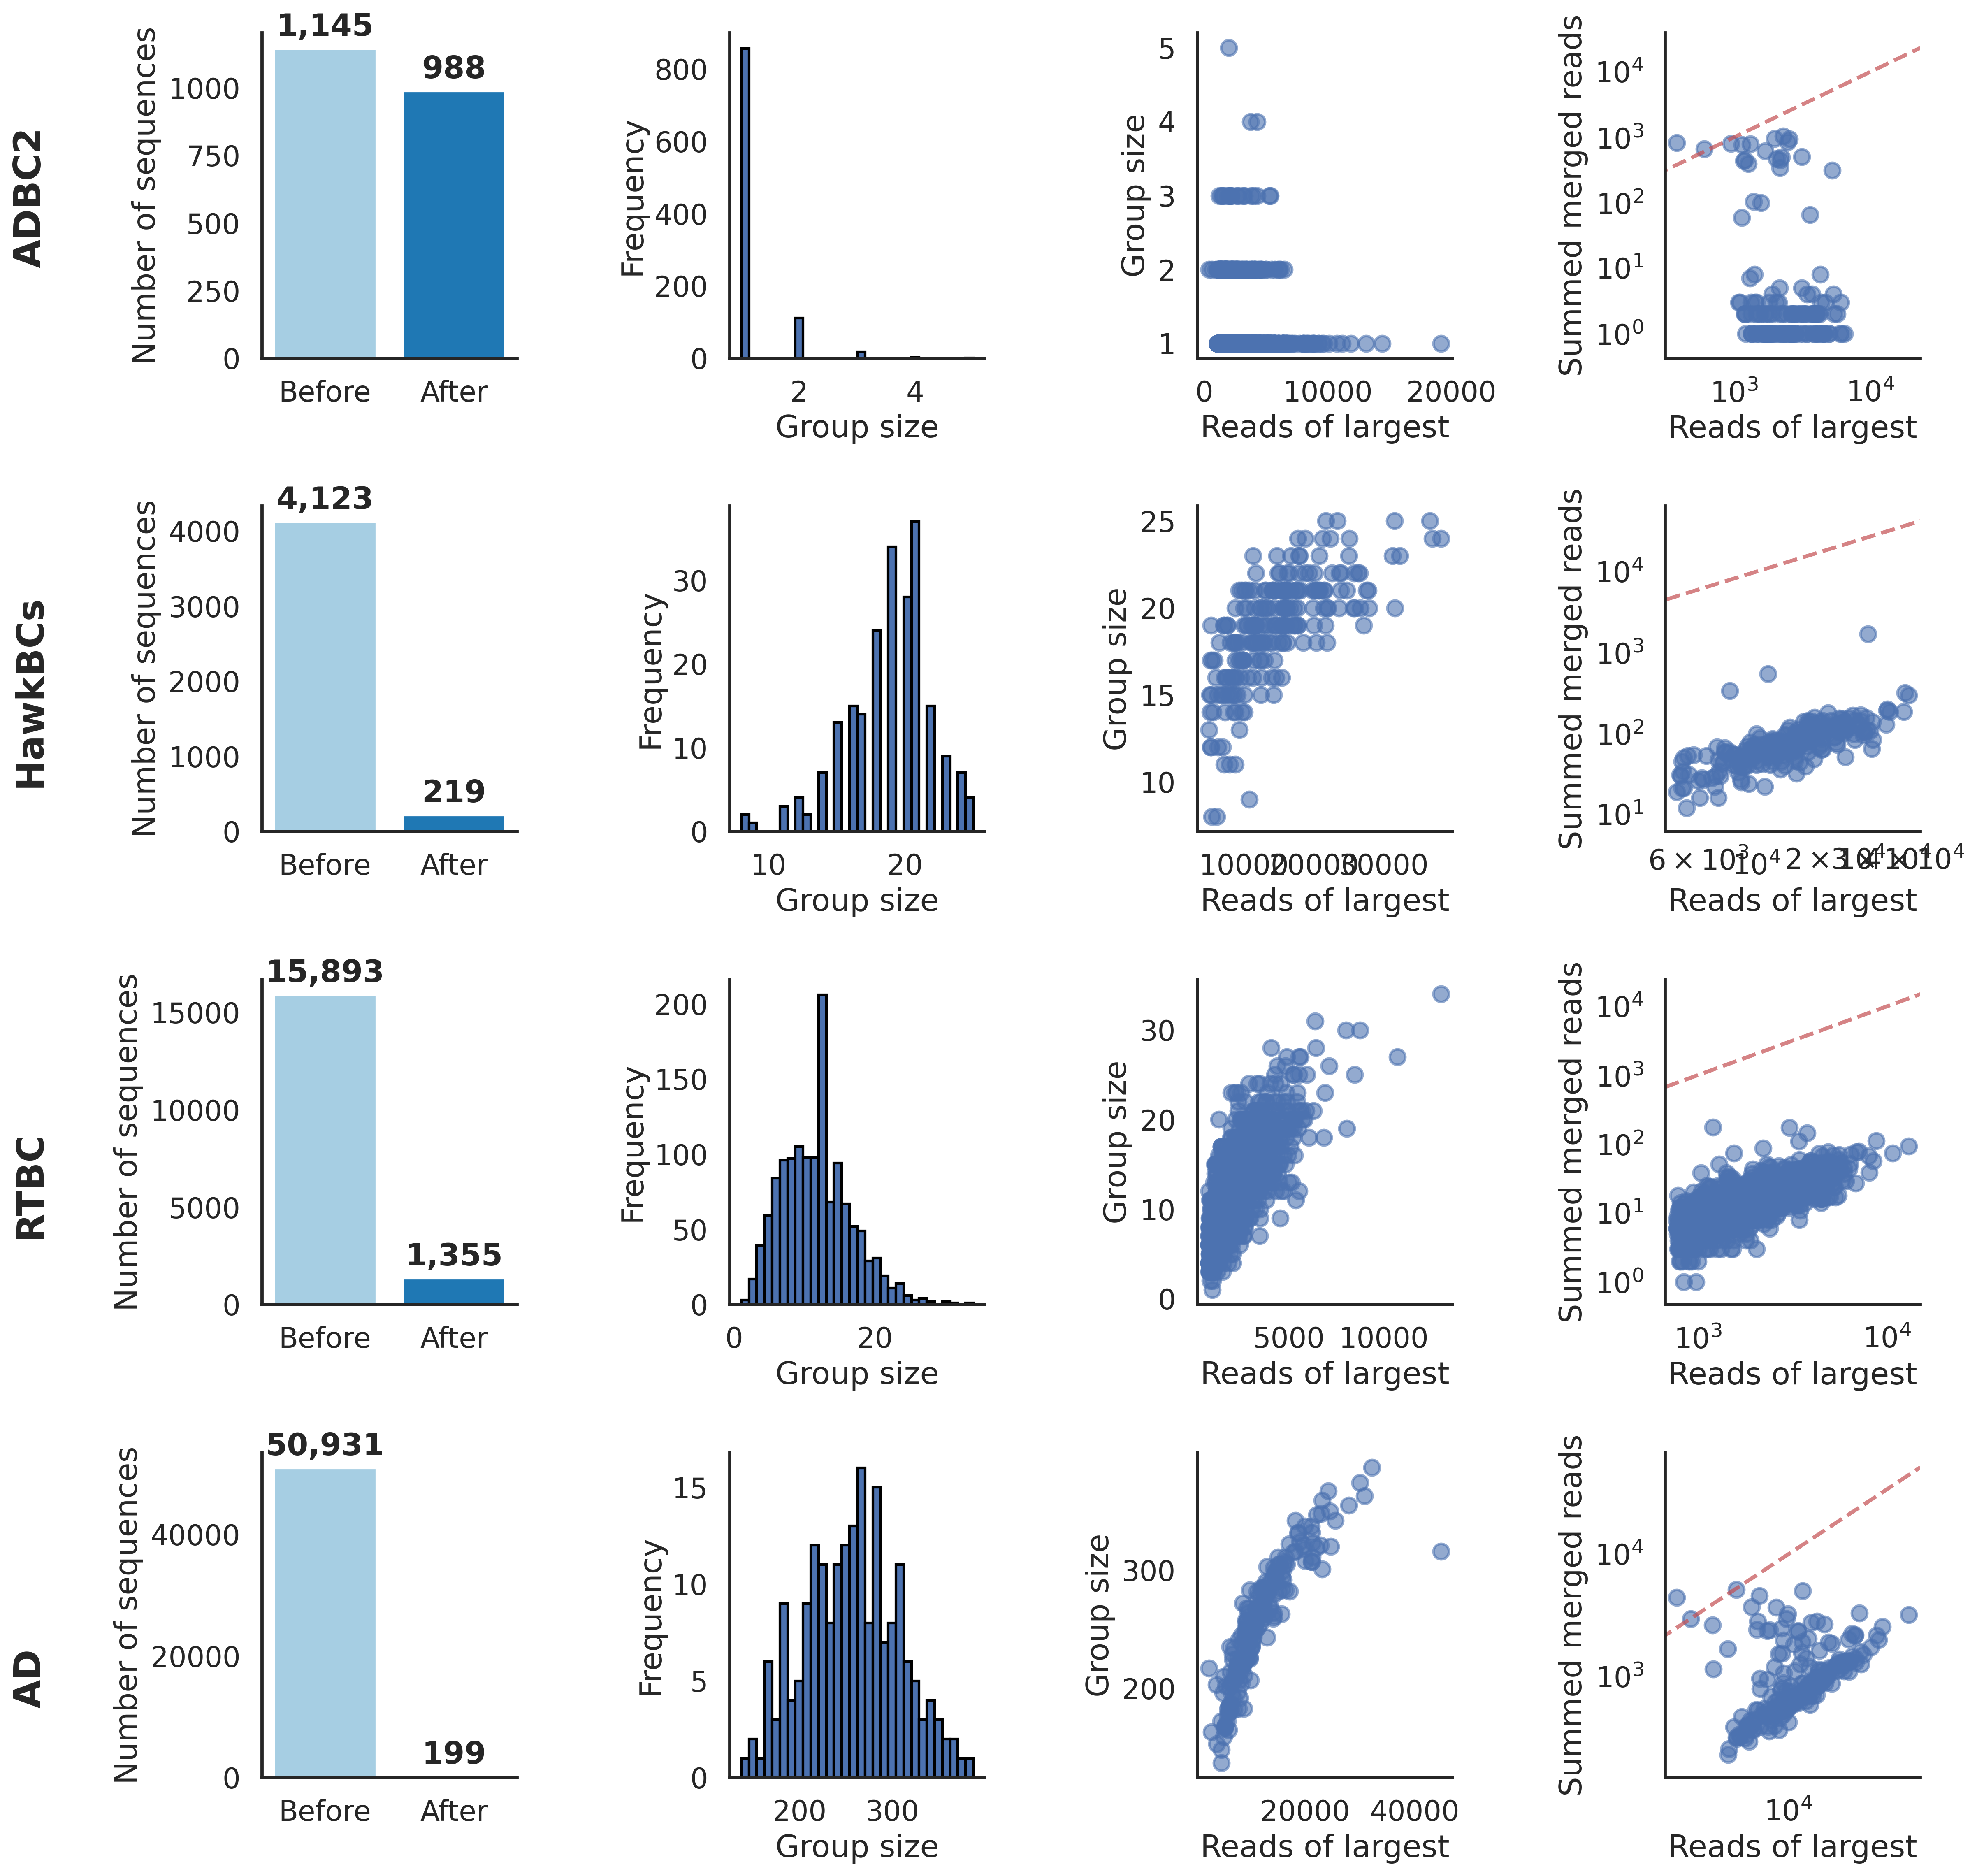

In [17]:
error_correct.plot_all_whitelists(barcodes = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                   output_dir = "../../data/NKX2-2_whitelist_test_function") 

In [18]:
mapper = initial_map.InitialMapper(db_path = "../../duckdb/NKX2-2_full_whitelist.db",
                                   seq_file = ['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq'],
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                        bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                      reverse_complement=False,
                                  step_name = "step1")

mapper.create_map()

Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 29.07 seconds.

Done in 0.00 seconds.

Extracting 4 barcodes...
CTCGAGATAACTTCGTATAATGTATGCTAT(.*)GGCCGGCCATAGGGCCCC
GAGCTCGCTAGC(.*)CTCGAGATAA
GGCCGGCCATAGGGCCCC(.*)GCGGTCCA
CACCATG(.*)GGATCCG
Done in 9.71 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 6.01 seconds.

Mapping complete.


In [65]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 15252011


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  TAACGT        True  CATCTTAGG          True  CAAAACGTAGCTTCTG       True   
1  TTTACG        True  ACCTGGAAC          True  GTGAGCGAAGTCTCCC       True   
2  CCCGAT        True  CCATTCTGC          True  CACTACGAAAGTCATA       True   
3  CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC       True   
4  CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
1  GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
2  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
4  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

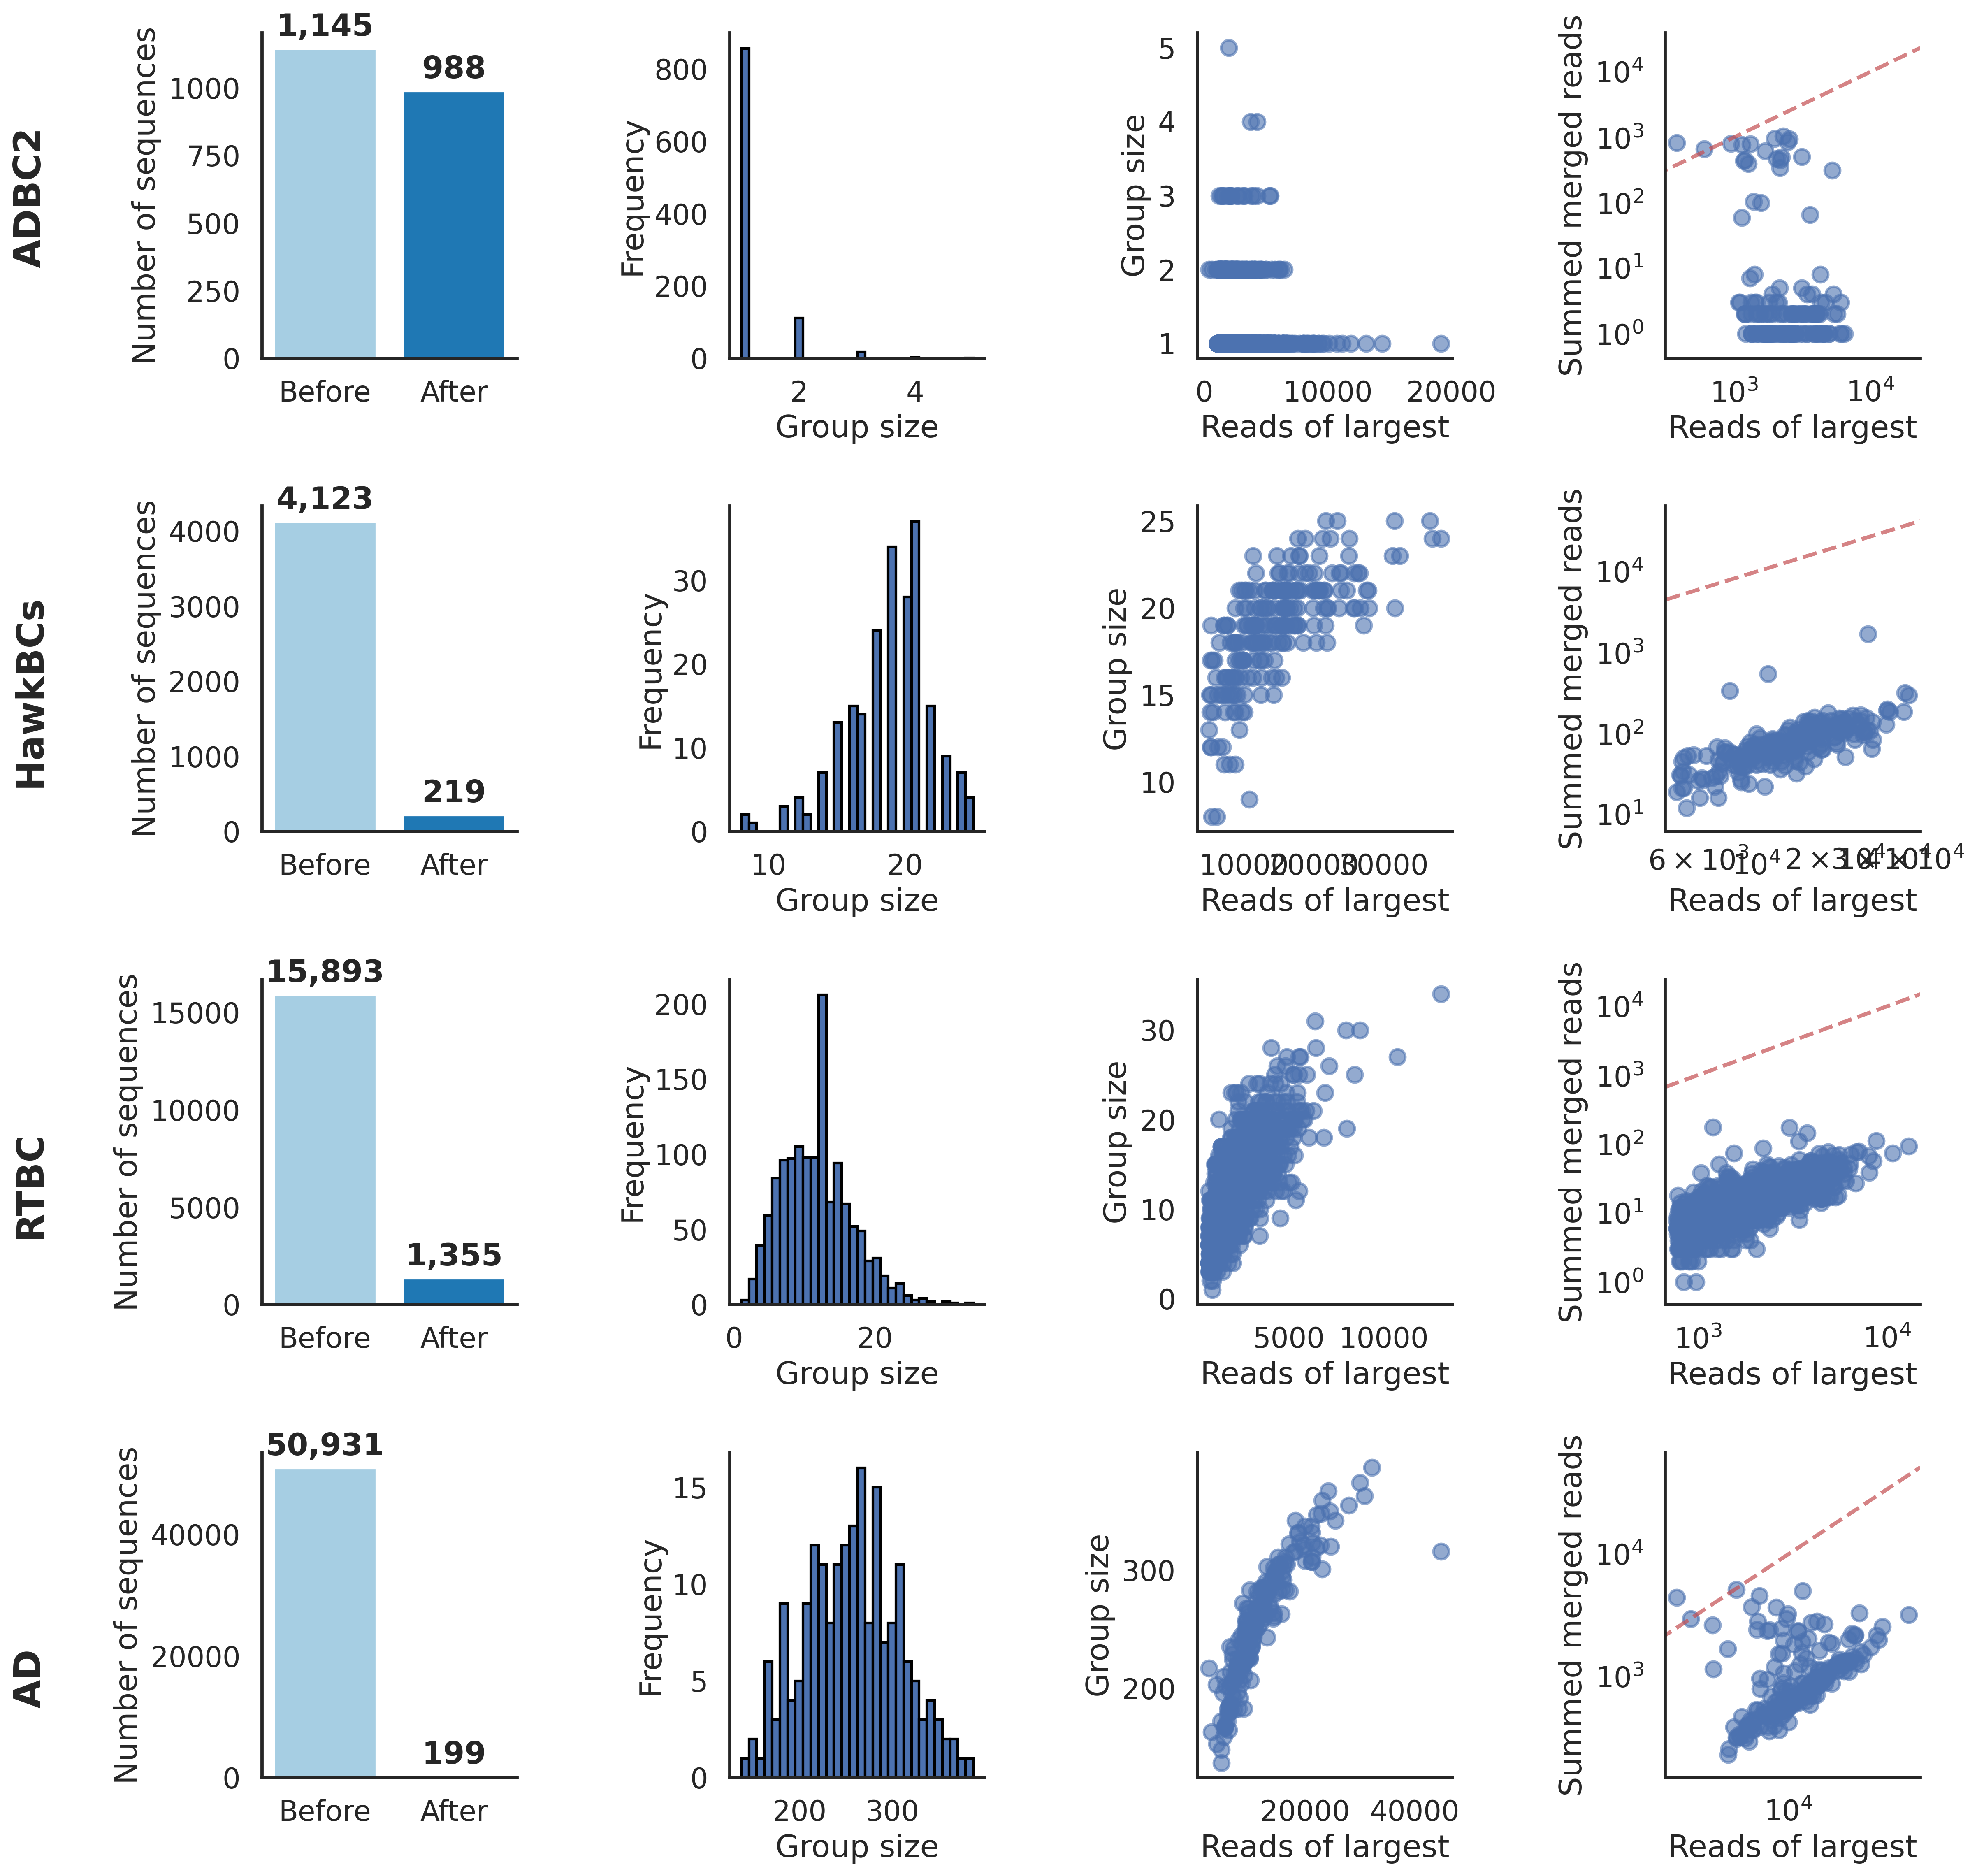

In [70]:
mapper.apply_whitelist("../../data/NKX2-2_whitelist_test_function/")

In [71]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 2862614


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  GTAGGA        True  ATTCGGTTC          True  AATAACCTGAGGGTCA       True   
1  CAGAAA        True  ACTTCCTCT          True  GCTGGAAAATCGTATT       True   
2  TGGGTA        True  ACCGACAAC          True  CTCACTACGATTACGT       True   
3  CCTATG        True  AAGTCTCAC          True  CTTACGCAGATGACTA       True   
4               False                    False  CCGAAAGCAAGAGGGC       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
1  GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...     True         1  
2  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     True         1  
4  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1

In [72]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full_whitelist.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 5,
                        map_order = ['grouped', 'barcode_exists', 'thresholded', 'unique_target', 'quality_designed'],
                        step_name = "step1",
                                should_check_exists = False, plot_histograms = True,
                                min_fraction = 0.9,
                                descriptor = "overlap_prop")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. grouped
3. barcode_exists
4. thresholded
5. unique_target
6. quality_designed



Grouping step1_ADBC2_HawkBCs_RTBC_AD_initial...


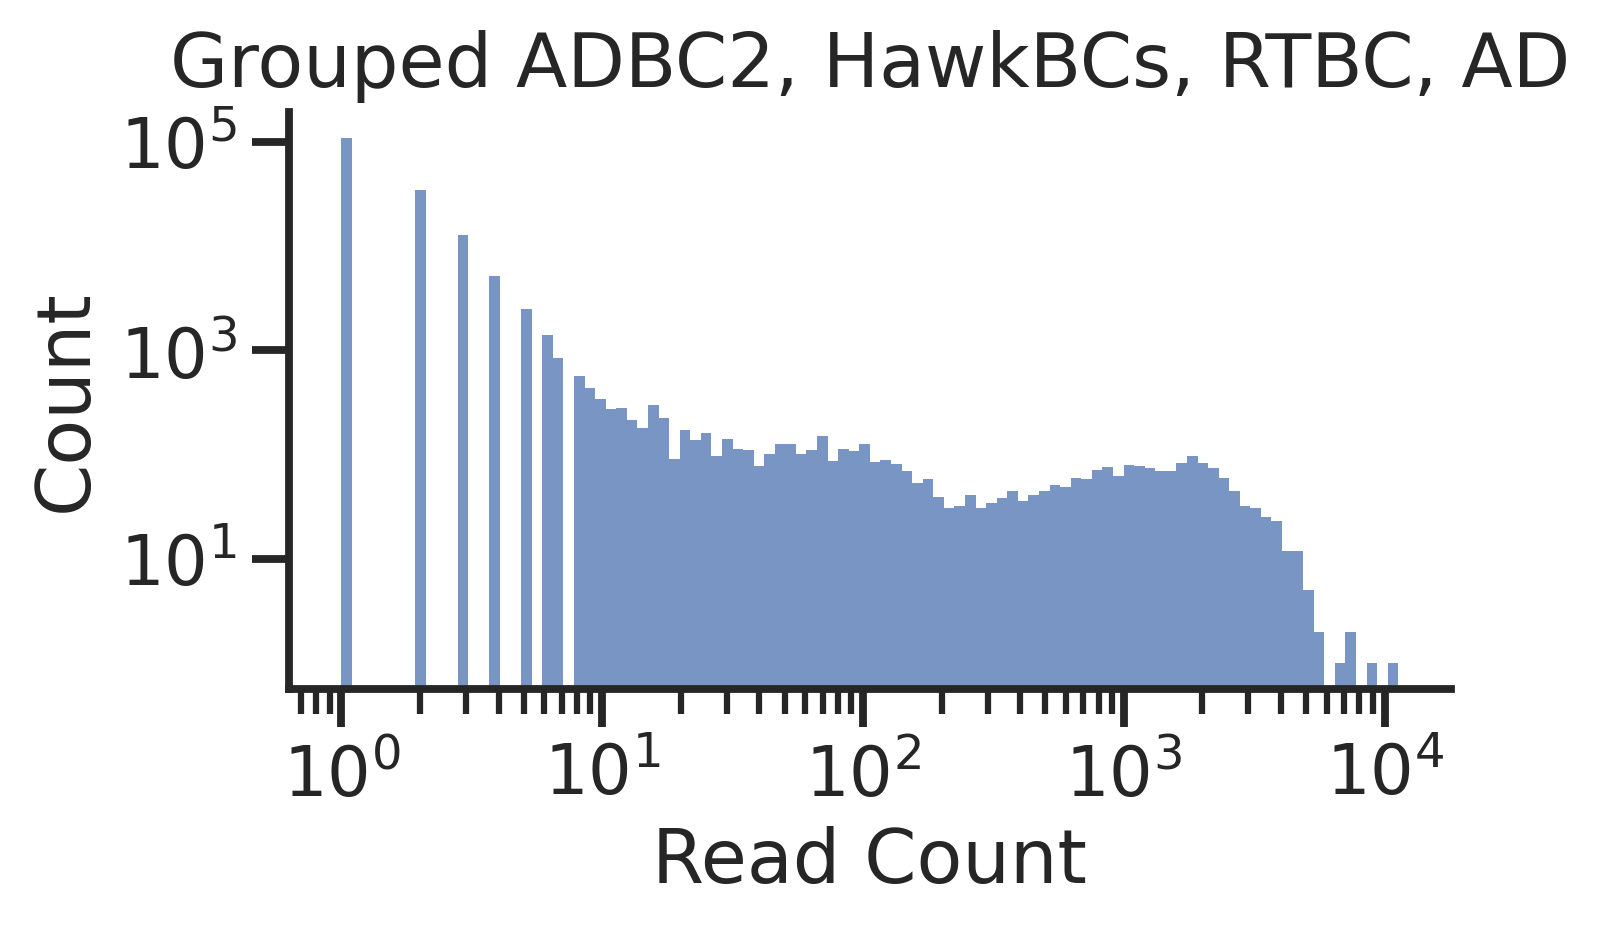

Done in 0.74 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.21 seconds.

Thresholding...
Using reads threshold of 5.


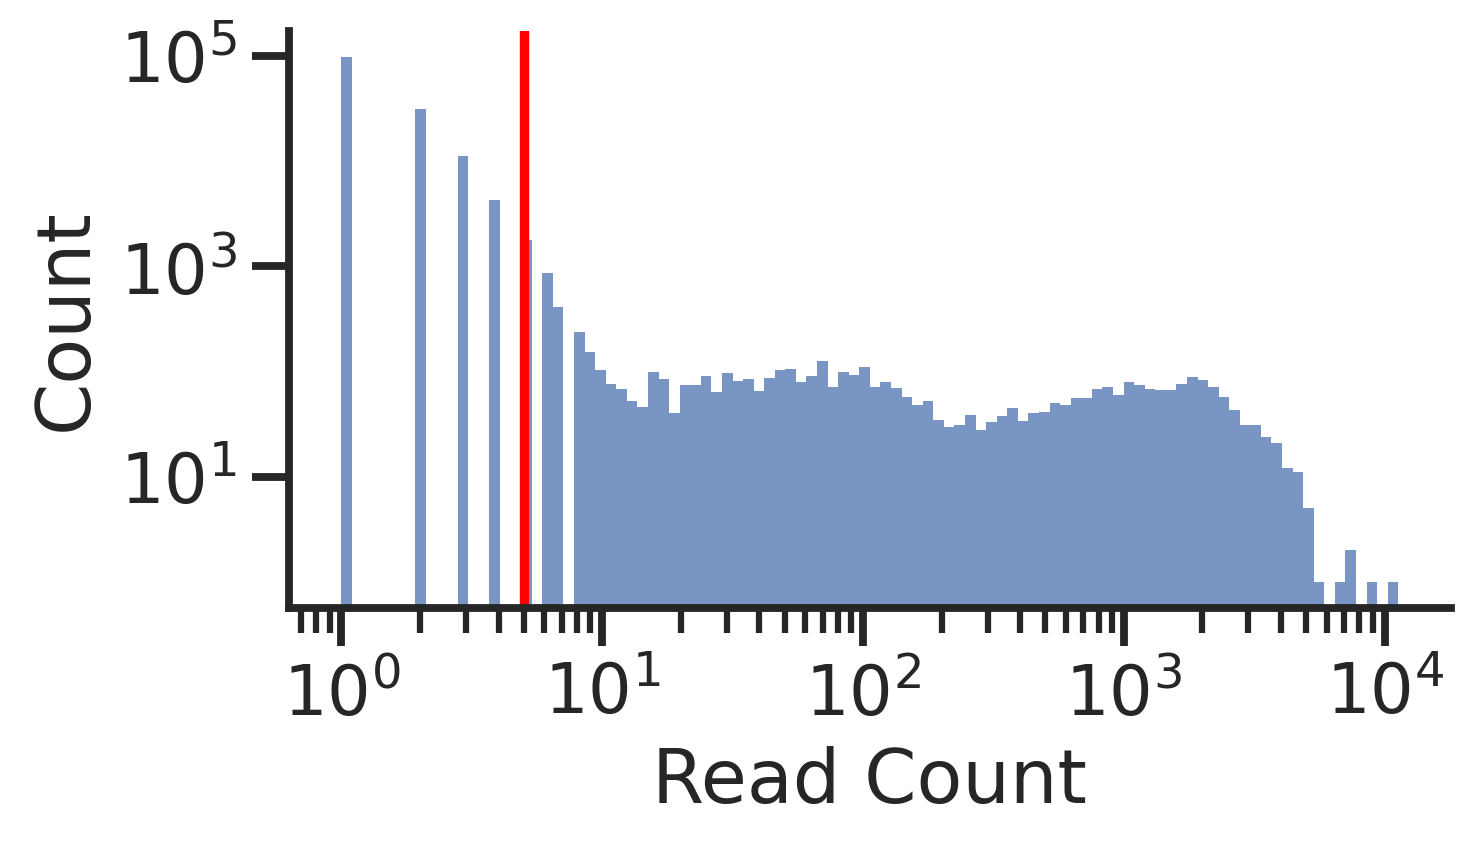

Done in 0.46 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_unique_target
Done in 0.03 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


In [75]:
refiner.refine_map_from_db()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.03 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.03 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

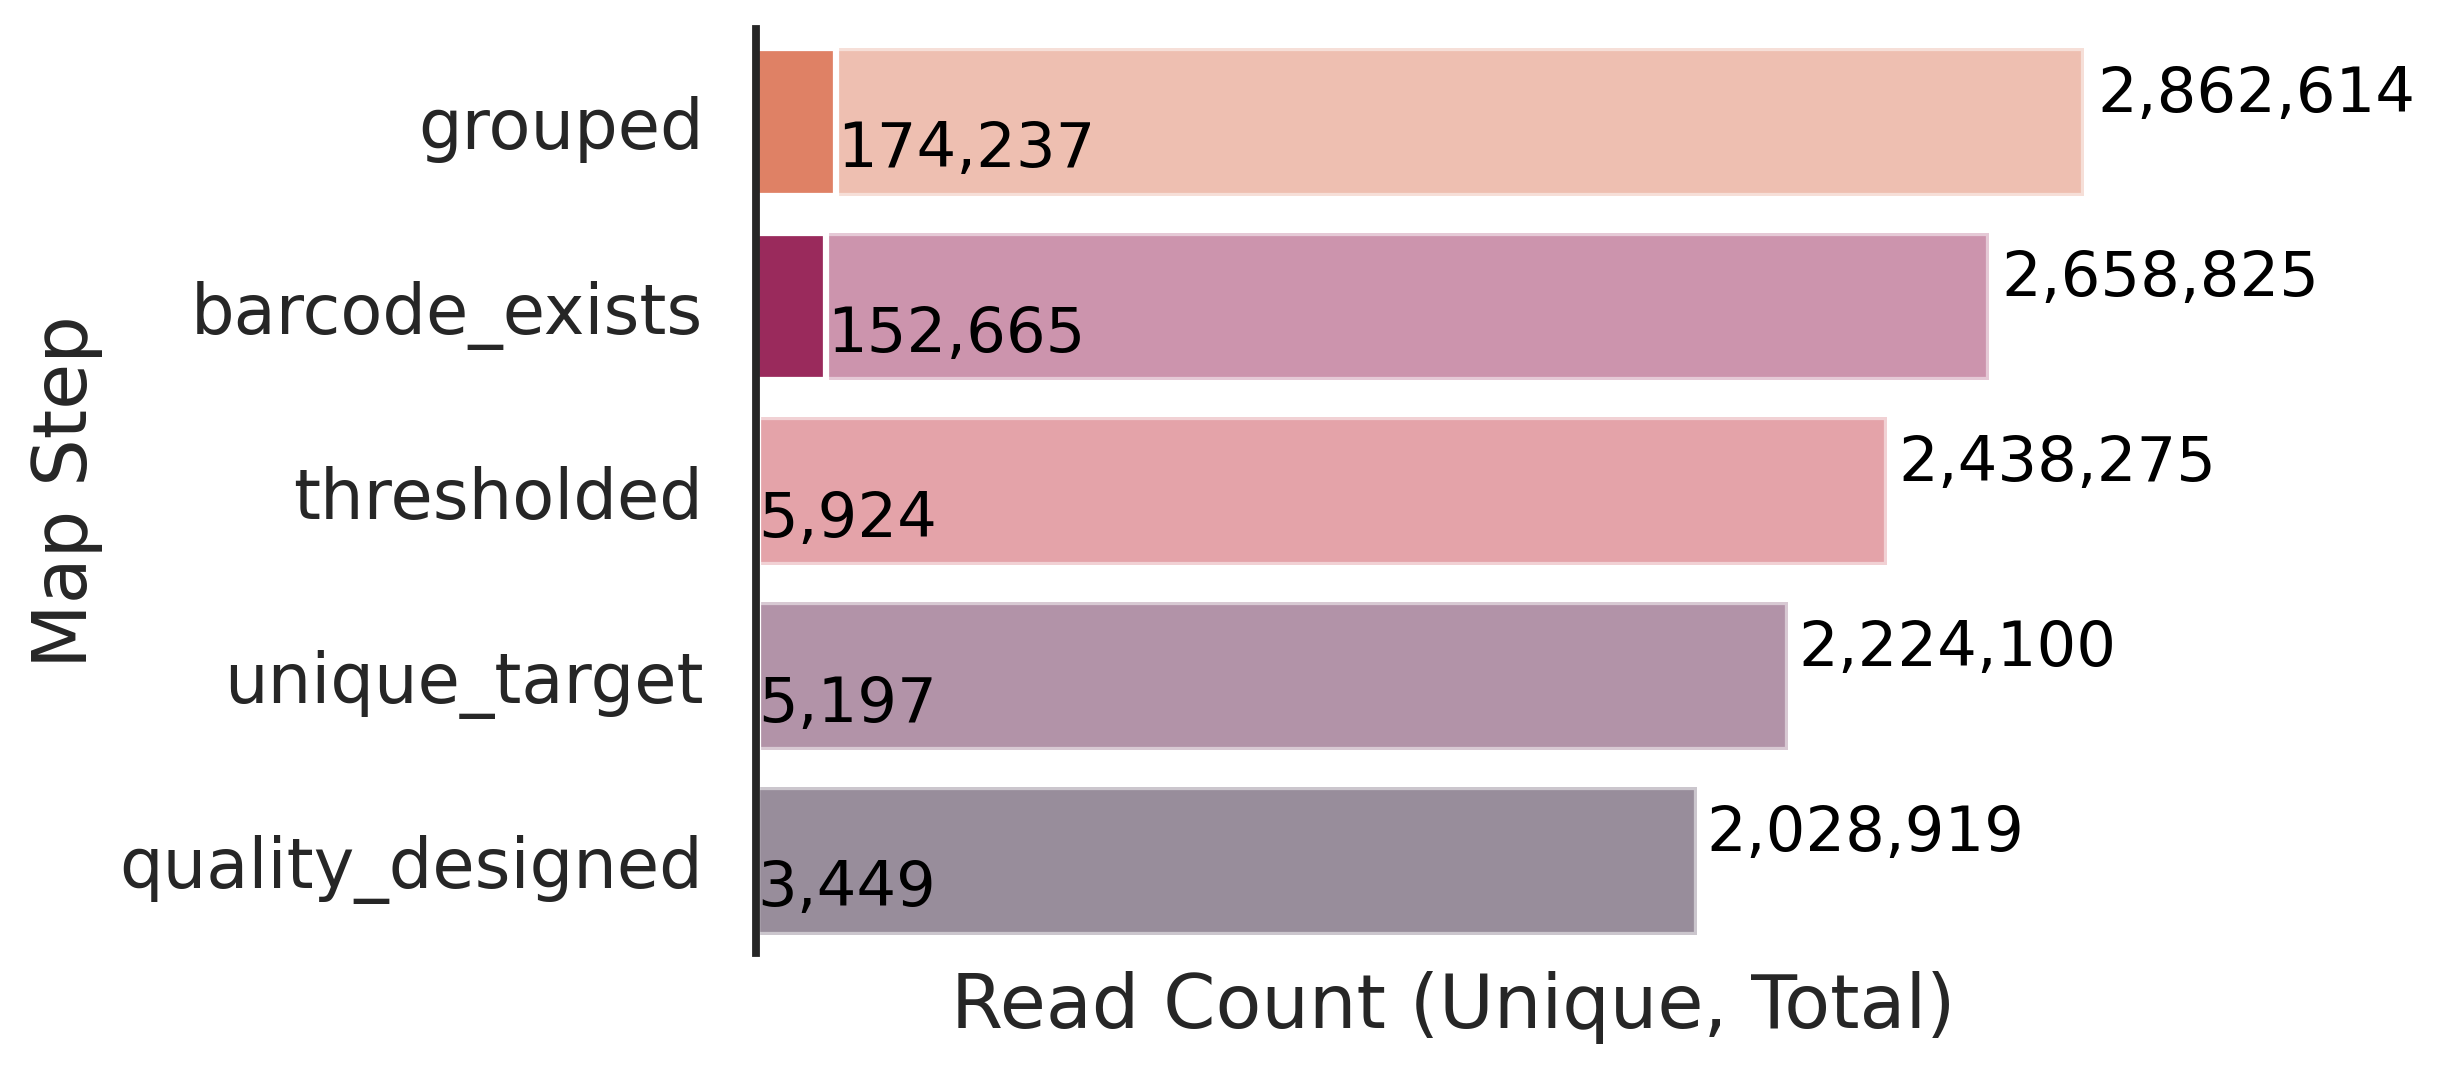

In [76]:
refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

In [78]:
quality_designed = refiner.get_map_df('quality_designed')
quality_designed

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
3444  TGTAAC  AGGACAAGT  TGCAAGTTGTATGTAA   
3445  TCCTTT  CAATCAACC  CACGGGGGATATTAGC   
3446  CTATAC  CACTGACTA  AAGATATGAAAGCTAA   
3447  GATGAA  ACGTCGAGA  AGATGTCGACATATTA   
3448  ACTTAT  AACAACACC  TTAATATGACCACGAG   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11280        True   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9331        True   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7305        True   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7166        True   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6466        True   
...                                                 ...    ...         ...   
3444  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3445  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3446  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3447  GCCTTCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3448  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  
0             True       True     True         1  
1             True       True     True         1  
2             True       True     True         1  
3             True       True     True         1  
4             True       True     True         1  
...            ...        ...      ...       ...  
3444          True       True     True         1  
3445          True       True     True         1  
3446          True       True     True         1  
3447          True       True     True         1  
3448          True       True     True         1  

[3449 rows x 10 columns]

<Axes: ylabel='Count'>

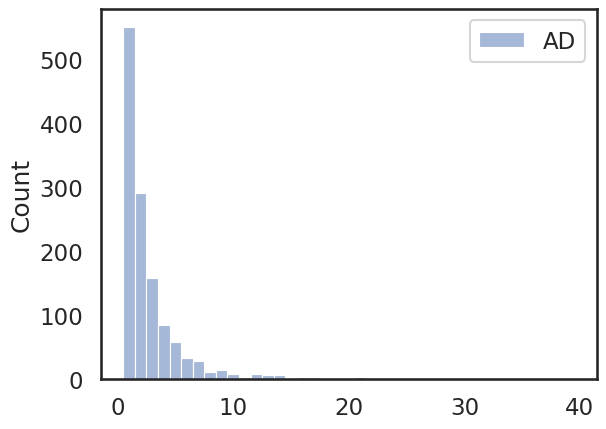

In [79]:
# How many ADs does a ADBC2 map back to?
sns.histplot(quality_designed[["ADBC2", "AD"]].drop_duplicates().groupby("ADBC2").count(), discrete = True)

<Axes: ylabel='Count'>

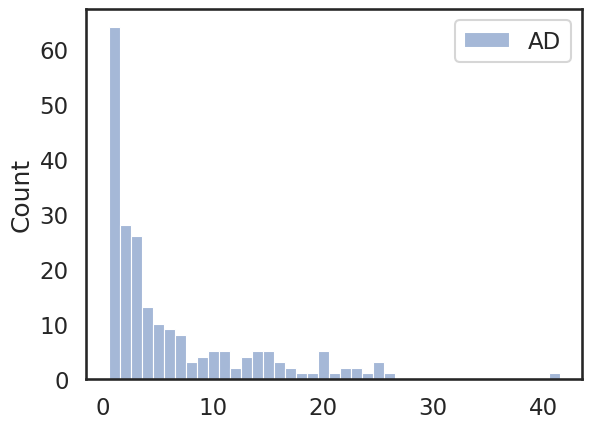

In [80]:
# How many ADs does a Hawk BC map back to?
sns.histplot(quality_designed[["HawkBCs", "AD"]].drop_duplicates().groupby("HawkBCs").count(), discrete = True)

In [ ]:
# try both barcodes
# hawkin first and then adbc2 next

In [ ]:
# wl_df = pd.read_csv("../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt", sep="\t", header=None,
#                     names=["canonical", "collapsed", "total_count", "counts"])
# # Create a dict: key = original barcode, value = canonical barcode
# barcode_correction = {}

# for _, row in wl_df.iterrows():
#     # Add canonical itself
#     barcode_correction[row["canonical"]] = row["canonical"]
    
#     # Add all collapsed barcodes
#     if pd.notna(row["collapsed"]):
#         for bc in row["collapsed"].split(","):
#             barcode_correction[bc] = row["canonical"]

In [ ]:
# barcode_correction